In [ ]:
#MOUNTING YOUR GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
###Analysis of Kaggle dataset###
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report

#RELEVANT URL:
#url = 'https://www.kaggle.com/datasets/yasserh/insurance-claim-dataset/data'

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Kaggle/Insurance.csv')
df = df.dropna()  # Drop missing values

def create_models(df):
    # Encode categorical variables
    label_encoders = {}
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Define features and targets
    target_classification = 'insuranceclaim'
    target_regression = 'charges'
    X = df.drop(columns=[target_classification, target_regression])
    y_classification = df[target_classification]
    y_regression = df[target_regression]

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Feature selection based on classification target
    selector = SelectKBest(f_classif, k=4)
    X_selected = selector.fit_transform(X_scaled, y_classification)
    selected_features_class = X.columns[selector.get_support()]
    print("Selected Features for Classification:", list(selected_features_class))

    # Feature selection based on regression target
    reg_selector = SelectKBest(f_regression, k=4)
    X_reg_selected = reg_selector.fit_transform(X_scaled, y_regression)
    selected_features_reg = X.columns[reg_selector.get_support()]
    print("Selected Features for Regression:", list(selected_features_reg))

    # Train-test split for classification
    X_train, X_test, y_train_class, y_test_class = train_test_split(
        X_selected, y_classification, test_size=0.2, random_state=42, stratify=y_classification
    )

    # Train-test split for regression
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg_selected, y_regression, test_size=0.2, random_state=42
    )

    # Train classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train_class)

    # Evaluate classifier
    y_pred_class = clf.predict(X_test)
    print("Classifier Accuracy:", accuracy_score(y_test_class, y_pred_class))
    print(classification_report(y_test_class, y_pred_class))

    # Train regressor
    reg = RandomForestRegressor(n_estimators=100, random_state=42)
    reg.fit(X_train_reg, y_train_reg)

    # Evaluate regressor
    r2_score = reg.score(X_test_reg, y_test_reg)

    # Print the feature importances for the classifier
    print("\nClassification Model Feature Importances:")
    sorted_class = sorted(zip(selected_features_class, clf.feature_importances_), key=lambda x: x[1], reverse=True)
    for feature, importance in sorted_class:
        print(f"{feature}: {importance:.4f}")

    # Print the feature importances for the regressor
    print("\nRegression Model Feature Importances:")
    sorted_reg = sorted(zip(selected_features_reg, reg.feature_importances_), key=lambda x: x[1], reverse=True)
    for feature, importance in sorted_reg:
        print(f"{feature}: {importance:.4f}")
    print("Regressor R^2:", r2_score)

    # Return necessary variables for prediction function
    return clf, reg, scaler, selector, reg_selector, label_encoders, selected_features_class, selected_features_reg

# Prediction function
def predict_insurance_claim(input_data, clf, reg, scaler, selector, reg_selector, label_encoders, selected_features_class, selected_features_reg, full_feature_columns):
    """
    Predicts the probability of claim approval and expected insurance charges.
    """
    input_df = pd.DataFrame([input_data])

    # Handle categorical variables using stored label encoders
    for col in label_encoders.keys():
        if col in input_df:
            if input_df[col].values[0] not in label_encoders[col].classes_:
                print(f"Warning: Unknown category '{input_df[col].values[0]}' in column '{col}'")
                input_df[col] = -1  # Assign an unknown category
            else:
                input_df[col] = label_encoders[col].transform(input_df[col])

    # Ensure the input has the same features as the training data
    input_df = input_df.reindex(columns=full_feature_columns, fill_value=0)

    # Scale input
    input_scaled = scaler.transform(input_df)

    # Apply feature selection
    input_selected_class = selector.transform(input_scaled)
    input_selected_reg = reg_selector.transform(input_scaled)

    # Predict probability of claim approval
    claim_prob = clf.predict_proba(input_selected_class)[:, 1][0]

    # Predict claim amount
    claim_amount = reg.predict(input_selected_reg)[0]

    return claim_prob, claim_amount

if __name__ == "__main__":
    clf, reg, scaler, selector, reg_selector, label_encoders, selected_features_class, selected_features_reg = create_models(df)

    # Full list of columns (for reindexing input)
    full_feature_columns = df.drop(columns=['insuranceclaim', 'charges']).columns

    example_person = {
        'age': 42,
        'sex': 1,
        'bmi': 22.2,
        'children': 0,
        'smoker': 1,
        'region': 3
    }

    prob, amount = predict_insurance_claim(example_person, clf, reg, scaler, selector, reg_selector, label_encoders, selected_features_class, selected_features_reg, full_feature_columns)
    print(f"Probability this person has an insurance claim: {prob:.2%}")
    print(f"Expected insurance payment: ${amount:,.2f}")



Selected Features for Classification: ['age', 'bmi', 'children', 'smoker']
Selected Features for Regression: ['age', 'bmi', 'children', 'smoker']
Classifier Accuracy: 0.9888059701492538
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       111
           1       0.99      0.99      0.99       157

    accuracy                           0.99       268
   macro avg       0.99      0.99      0.99       268
weighted avg       0.99      0.99      0.99       268


Classification Model Feature Importances:
bmi: 0.4240
children: 0.3185
smoker: 0.1486
age: 0.1090

Regression Model Feature Importances:
smoker: 0.6086
bmi: 0.2336
age: 0.1361
children: 0.0217
Regressor R^2: 0.8597330104345647
Probability this person has an insurance claim: 94.00%
Expected insurance payment: $21,172.07


In [ ]:
# MEPS Analysis

import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, r2_score
import warnings

# Load and clean MEPS data
def read_data():
    df_raw = pd.read_csv('/content/drive/MyDrive/Kaggle/h243.csv').drop_duplicates()

    def determine_insuranceStatus(col):
        if col == 1: return pd.NA
        if col == 2: return 1
        return pd.NA

    def determine_maritalStatus(col):
        if col in [1, 2]: return 1
        if col in [3, 4, 5, 6]: return 0
        return pd.NA

    def determine_employmentStatus(col):
        if col in [1, 2]: return 1
        if col == 3: return 0
        return pd.NA

    def determine_smokingStatus(col):
        if col in [1, 2]: return 1
        if col == 3: return 0
        return pd.NA

    df = pd.DataFrame({
        'age': df_raw['AGELAST'],
        'sex': df_raw['SEX'],
        'race': df_raw['RACEV2X'],
        'maritalStatus': df_raw['MARRY22X'].apply(determine_maritalStatus),
        'region': df_raw['REGION22'],
        'familySize': df_raw['FAMSZE22'],
        'reportedHealthIndicator': df_raw['RTHLTH53'],
        'hasInsurance': df_raw['UNINS22'].apply(determine_insuranceStatus),
        'employmentStatus': df_raw['EMPST53'].apply(determine_employmentStatus),
        'insuranceClaim': (df_raw['TOTEXP22'] - df_raw['TOTSLF22']).clip(lower=0),
        'insuranceClaimStatus': (df_raw['TOTEXP22'] - df_raw['TOTSLF22']).apply(lambda x: 1 if x > 0 else 0),
        'charges': df_raw['TOTEXP22'],
        'adultStatus': df_raw['ADBMI42'].replace(-1, pd.NA).notna().astype(int),
        'bmi': df_raw['ADBMI42'],
        'charges ': df_raw['OFTSMK53'].apply(determine_smokingStatus),
    })

    # create age_group for grouping only
    df['age_group'] = pd.cut(
        df['age'],
        bins=[0, 17, 44, 64, 120],
        labels=['child', 'young_adult', 'middle_aged', 'senior']
    )

    # Only drop rows missing the critical targets or features
    essential = [
        'age', 'sex', 'race', 'maritalStatus', 'region', 'familySize',
        'reportedHealthIndicator', 'employmentStatus',
        'insuranceClaimStatus', 'charges', 'bmi', 'smokingStatus'
    ]
    return df.dropna(subset=essential)

# Modeling function per subgroup
def create_models_by_group(df, group_col):
    subgroups = sorted(df[group_col].dropna().unique(), key=lambda x: (isinstance(x, str), x))
    for group in subgroups:
        subgroup_df = df[df[group_col] == group]
        print(f"\n===== {group_col.upper()} = {group} ====================")

        # copy & remove age_group so it's never a feature
        df_encoded = subgroup_df.copy()
        if 'age_group' in df_encoded.columns:
            df_encoded.drop(columns=['age_group'], inplace=True)

        # Encode categorical features
        for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

        # Drop rows missing our targets
        df_encoded = df_encoded.dropna(subset=['insuranceClaimStatus', 'charges'])
        if df_encoded.empty:
            print("  No data after dropping missing targets.")
            continue

        # Classification target: did they file a claim?
        y_class = df_encoded['insuranceClaimStatus'].astype(int)
        print("#Claimers(1), #Non-claimers(0):", y_class.value_counts().to_dict())

        # Build feature matrix without any derived grouping columns
        X = df_encoded.drop(columns=[
            'insuranceClaimStatus',
            'charges',
            'insuranceClaim',
            'hasInsurance'
        ])
        feature_cols = X.columns.tolist()

        # Standardize features
        X_scaled = StandardScaler().fit_transform(X)

        # ---- Classification ----
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                warnings.simplefilter("ignore", category=RuntimeWarning)

                selector = SelectKBest(f_classif, k=min(4, X_scaled.shape[1]))
                X_class = selector.fit_transform(X_scaled, y_class)
                feat_class = [feature_cols[i]
                              for i, keep in enumerate(selector.get_support())
                              if keep]

            if len(y_class.unique()) < 2:
                print("  Skipping classifier: not enough class variation.")
            else:
                Xc_train, Xc_test, yc_train, yc_test = train_test_split(
                    X_class, y_class,
                    test_size=0.2,
                    stratify=y_class,
                    random_state=42
                )
                clf = RandomForestClassifier(
                    n_estimators=100,
                    class_weight='balanced',
                    random_state=42
                )
                clf.fit(Xc_train, yc_train)
                yc_pred = clf.predict(Xc_test)

                print("\nClassifier Accuracy:", accuracy_score(yc_test, yc_pred))
                print(classification_report(yc_test, yc_pred, zero_division=0))
                print("Classification Feature Importances:")
                for f, imp in sorted(zip(feat_class, clf.feature_importances_),
                                     key=lambda x: x[1], reverse=True):
                    print(f"  {f}: {imp:.4f}")

        except ValueError as e:
            print(f"  Skipping classifier due to error: {e}")

        # ---- Regression ----
        y_reg = df_encoded['charges']
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                warnings.simplefilter("ignore", category=RuntimeWarning)

                selector = SelectKBest(f_regression, k=min(4, X_scaled.shape[1]))
                X_reg = selector.fit_transform(X_scaled, y_reg)
                feat_reg = [feature_cols[i]
                            for i, keep in enumerate(selector.get_support())
                            if keep]

            Xr_train, Xr_test, yr_train, yr_test = train_test_split(
                X_reg, y_reg,
                test_size=0.2,
                random_state=42
            )
            reg = RandomForestRegressor(n_estimators=100, random_state=42)
            reg.fit(Xr_train, yr_train)

            print("\nRegressor R²:", r2_score(yr_test, reg.predict(Xr_test)))
            print("Regression Feature Importances:")
            for f, imp in sorted(zip(feat_reg, reg.feature_importances_),
                                 key=lambda x: x[1], reverse=True):
                print(f"  {f}: {imp:.4f}")

        except ValueError as e:
            print(f"  Skipping regressor due to error: {e}")

if __name__ == "__main__":
    df = read_data()
    print("\n\n### BIAS ANALYSIS BY RACE ###")
    create_models_by_group(df, 'race')
    print("\n\n### BIAS ANALYSIS BY REGION ###")
    create_models_by_group(df, 'region')
    print("\n\n### BIAS ANALYSIS BY AGE GROUP ###")
    create_models_by_group(df, 'age_group')




### BIAS ANALYSIS BY RACE ###

===== RACE = 1 ====================
#Claimers(1), #Non-claimers(0): {1: 6399, 0: 1597}

Classifier Accuracy: 0.716875
              precision    recall  f1-score   support

           0       0.30      0.33      0.31       320
           1       0.83      0.81      0.82      1280

    accuracy                           0.72      1600
   macro avg       0.57      0.57      0.57      1600
weighted avg       0.72      0.72      0.72      1600

Classification Feature Importances:
  age: 0.4416
  bmi: 0.3803
  familySize: 0.1382
  sex: 0.0400

Regressor R²: -0.3792389485238945
Regression Feature Importances:
  age: 0.4996
  familySize: 0.2479
  reportedHealthIndicator: 0.1782
  sex: 0.0743

===== RACE = 2 ====================
#Claimers(1), #Non-claimers(0): {1: 1101, 0: 391}

Classifier Accuracy: 0.6588628762541806
              precision    recall  f1-score   support

           0       0.34      0.32      0.33        78
           1       0.76      0.78   

In [ ]:
df.head()

,age,sex,race,maritalStatus,region,familySize,reportedHealthIndicator,hasInsurance,employmentStatus,insuranceClaim,insuranceClaimStatus,charges,adultStatus,bmi,smokingStatus,age_group
3,29,1,12,0,4,1,4,1,1,8100,1,9265,0,-1.0,1,young_adult
4,51,2,1,0,1,1,2,1,1,2671,1,3362,1,27.4,0,middle_aged
5,58,1,1,0,4,1,2,<NA>,1,0,0,35,1,20.8,0,middle_aged
6,42,1,1,0,4,2,2,1,1,3270,1,5710,0,-1.0,0,young_adult
8,53,2,1,1,1,2,2,1,1,16081,1,18165,1,43.3,0,middle_aged



--- Generating Plots for Group: race ---


<ipython-input-17-398fc334bea4>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group_label', y='value', data=acc_data, ax=current_ax, palette='viridis', order=plot_order)
<ipython-input-17-398fc334bea4>:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group_label', y='value', data=r2_data, ax=current_ax, palette='coolwarm', order=plot_order)



--- Generating Accuracy vs R-squared Plot for Group: race ---

--- Generating Plots for Group: region ---


<ipython-input-17-398fc334bea4>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group_label', y='value', data=acc_data, ax=current_ax, palette='viridis', order=plot_order)
<ipython-input-17-398fc334bea4>:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group_label', y='value', data=r2_data, ax=current_ax, palette='coolwarm', order=plot_order)



--- Generating Accuracy vs R-squared Plot for Group: region ---

--- Generating Plots for Group: age_group ---


<ipython-input-17-398fc334bea4>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group_label', y='value', data=acc_data, ax=current_ax, palette='viridis', order=plot_order)
<ipython-input-17-398fc334bea4>:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group_label', y='value', data=r2_data, ax=current_ax, palette='coolwarm', order=plot_order)



--- Generating Accuracy vs R-squared Plot for Group: age_group ---

Displaying generated plots...


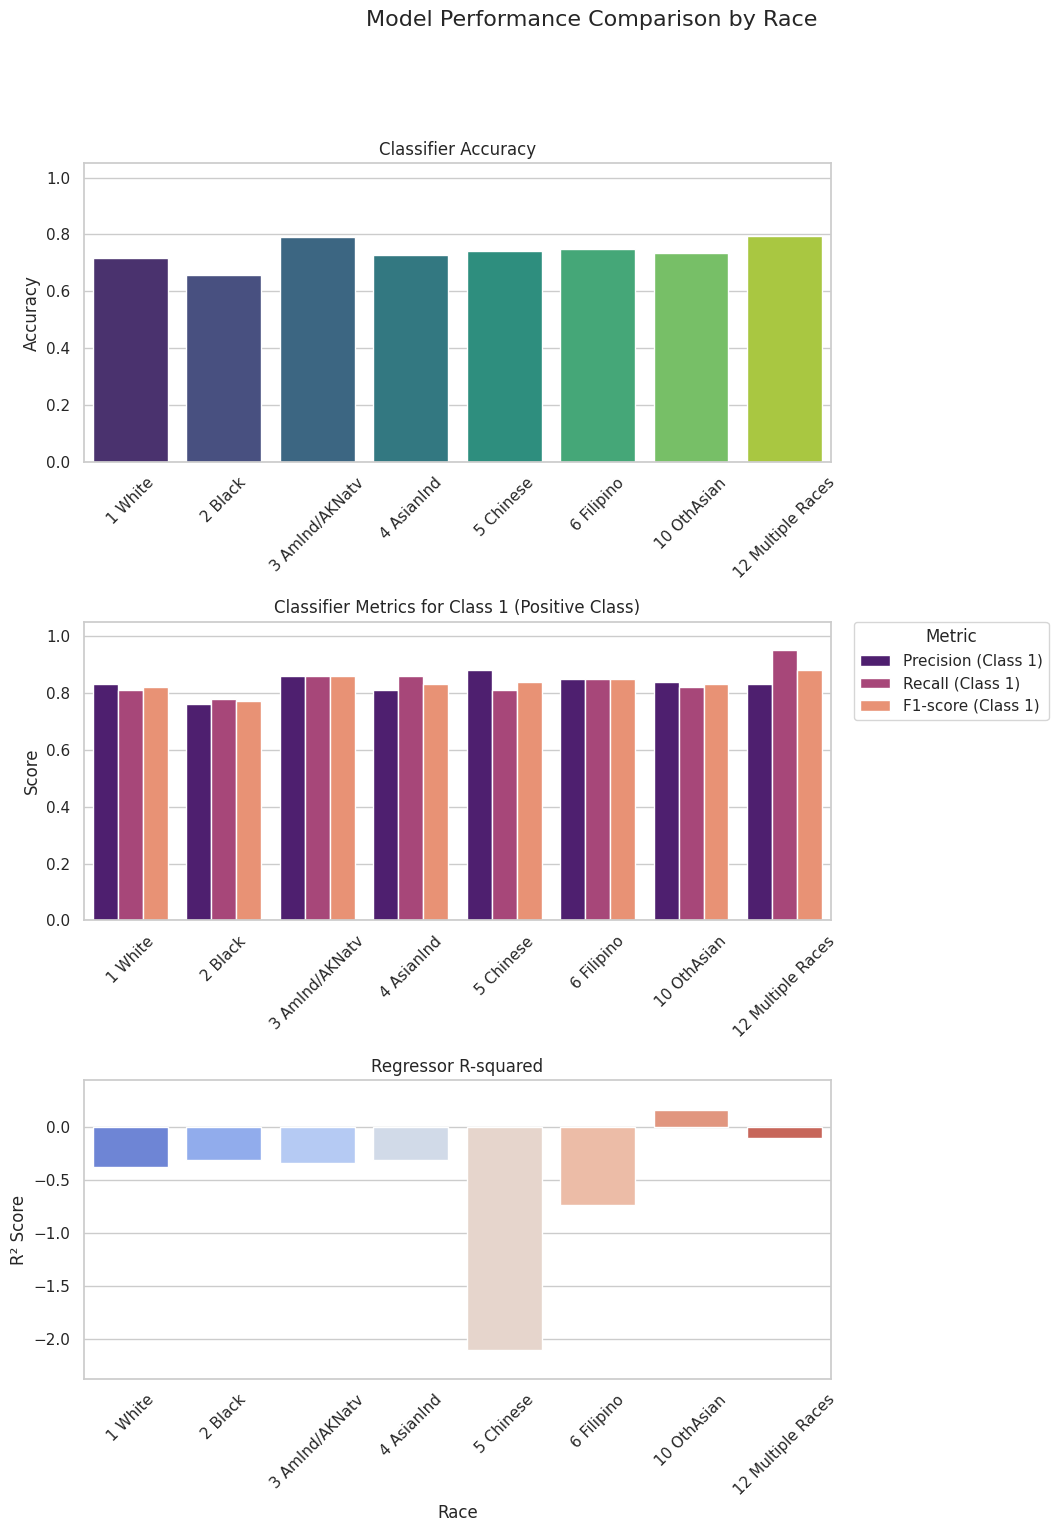

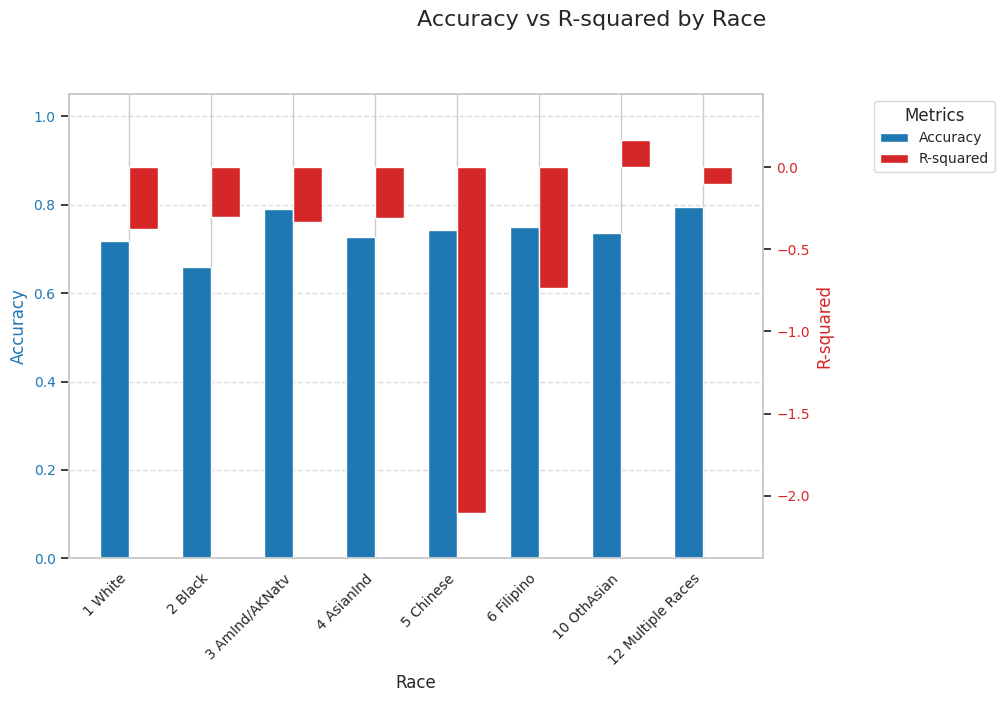

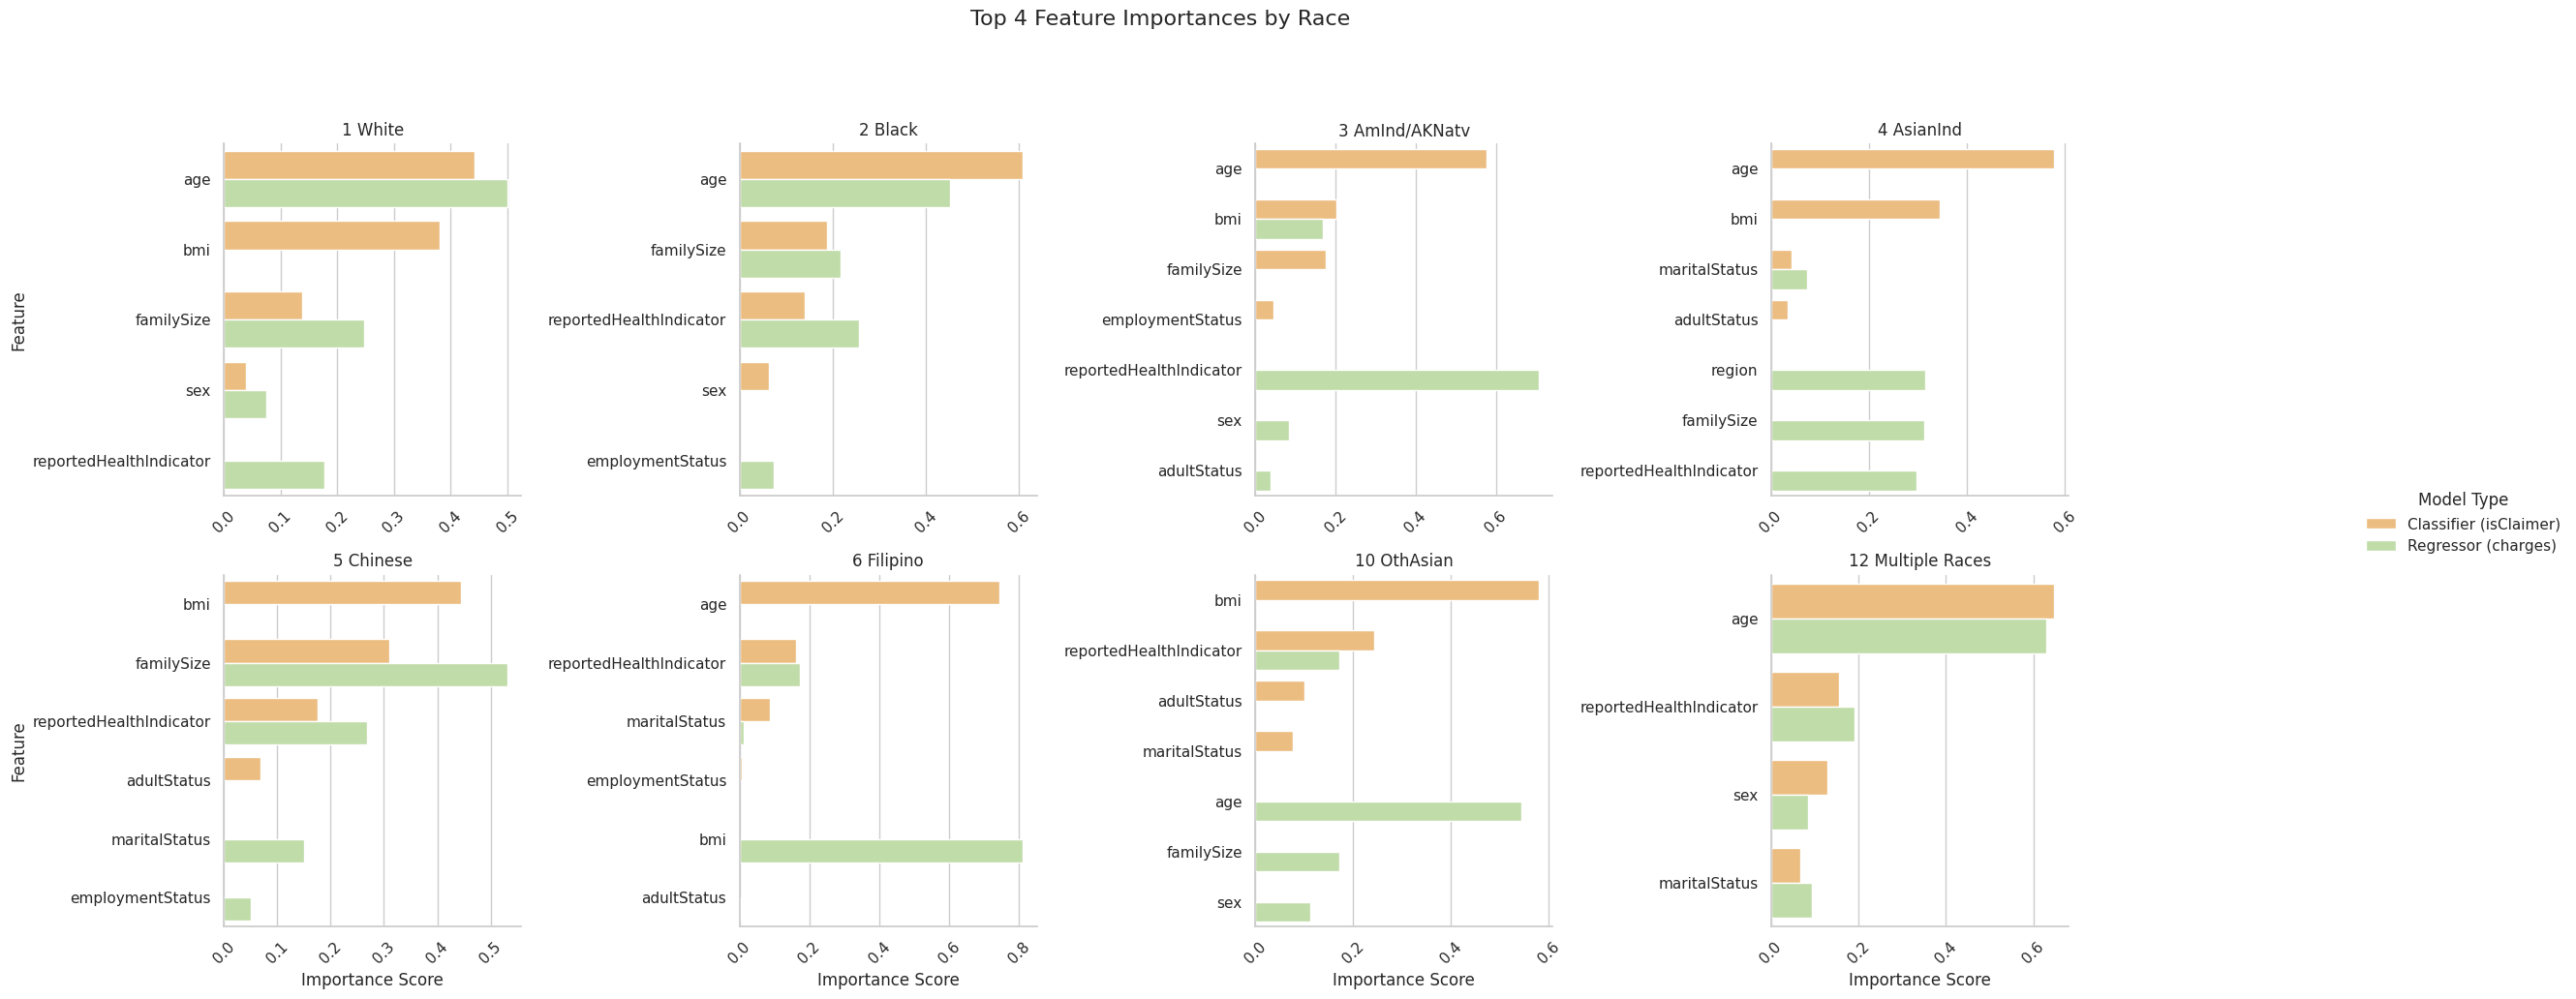

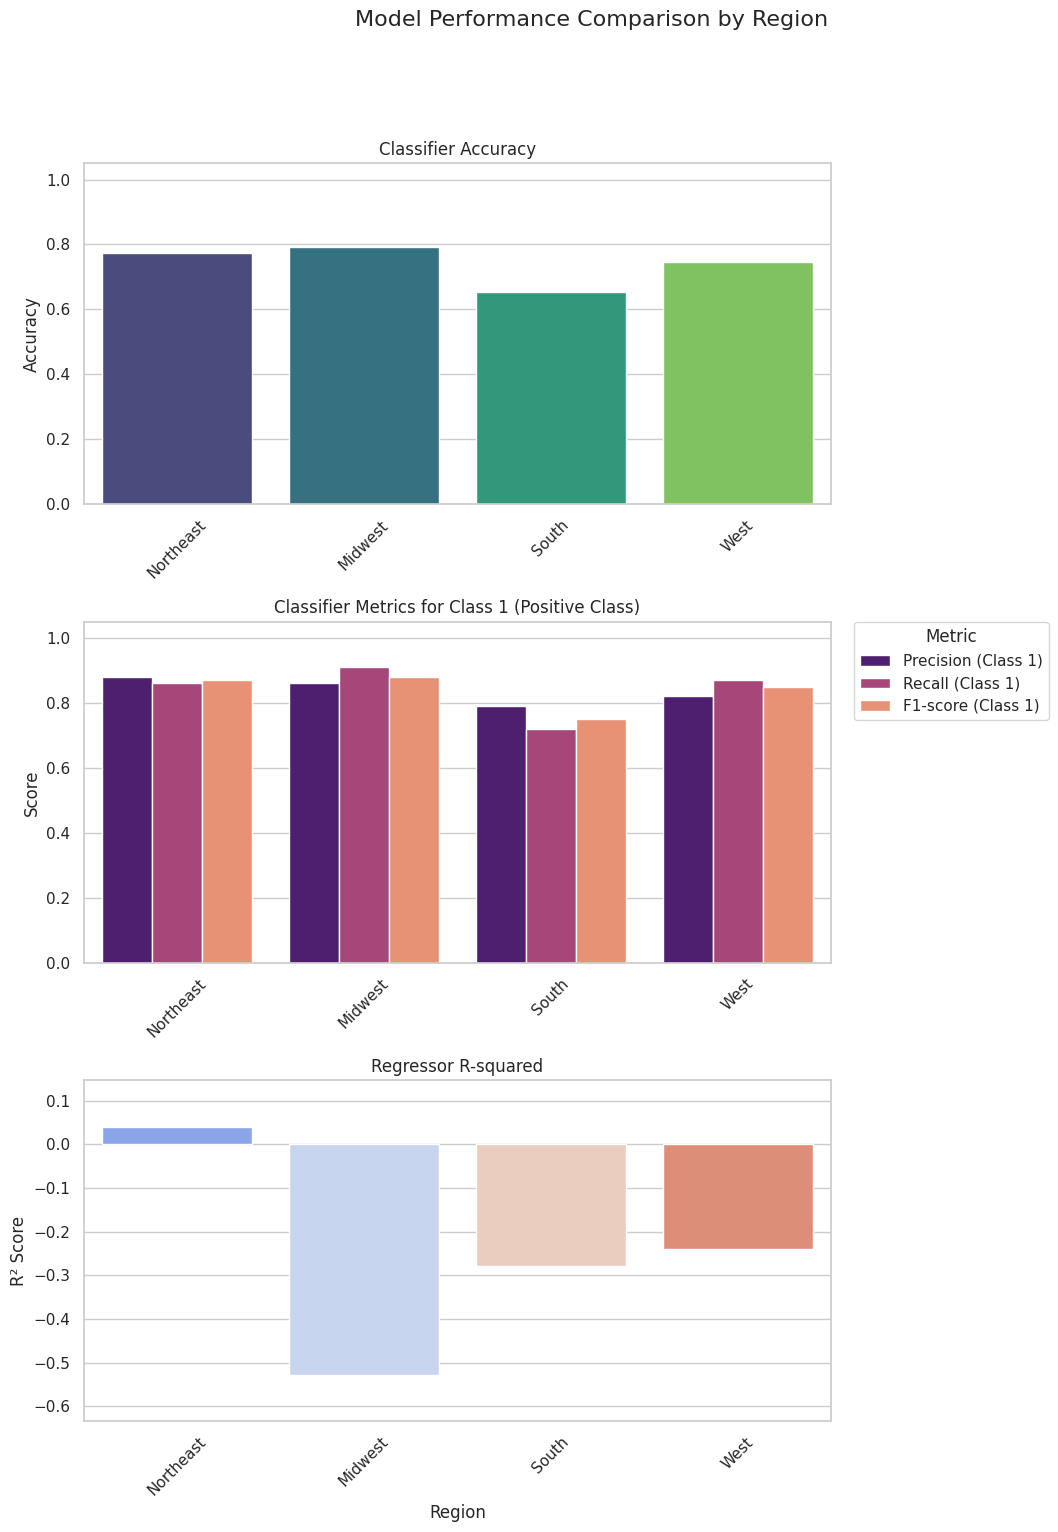

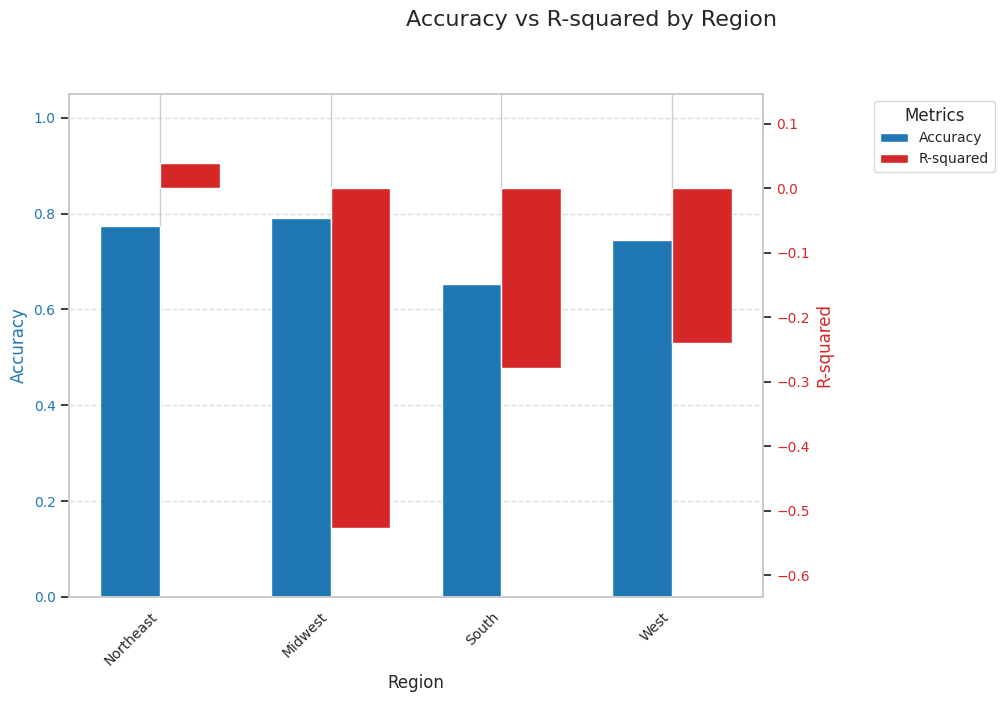

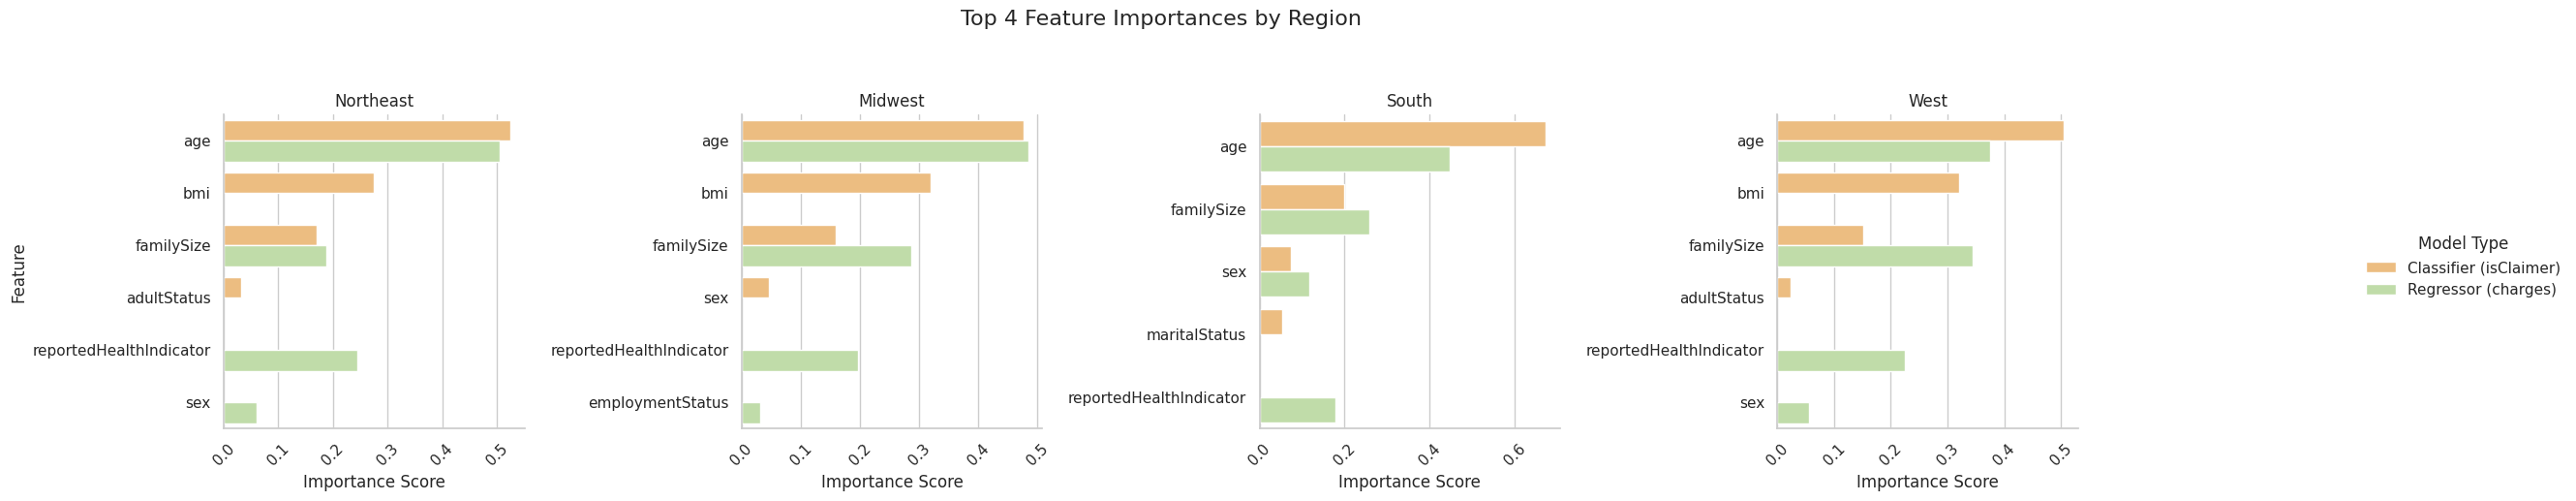

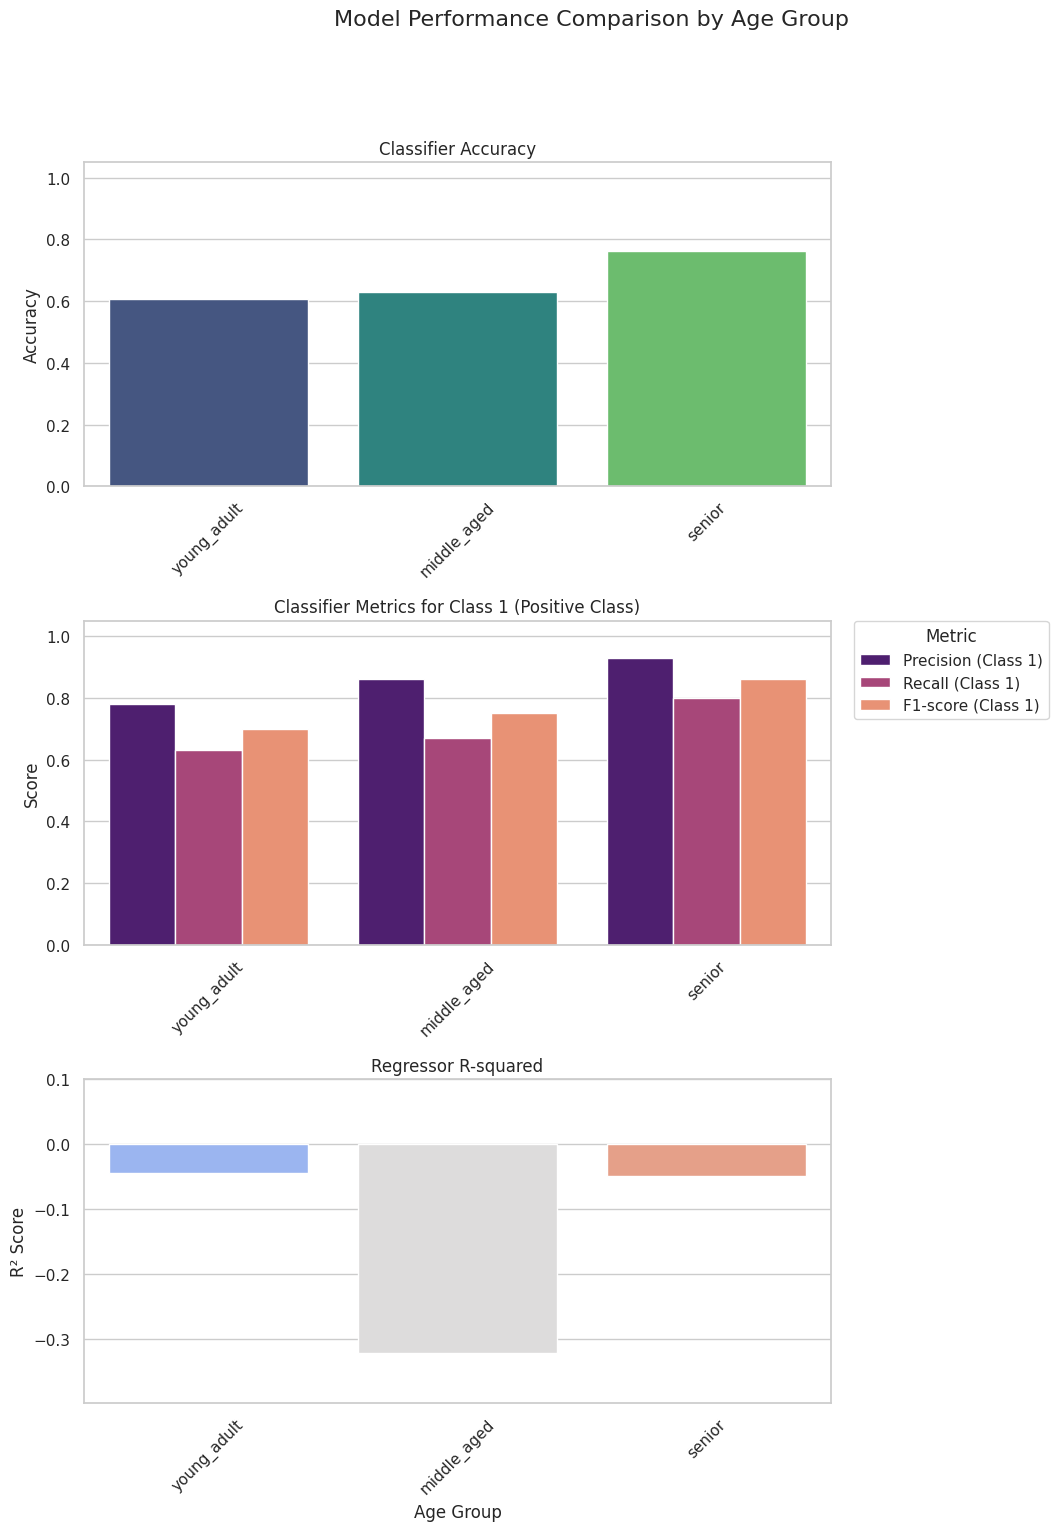

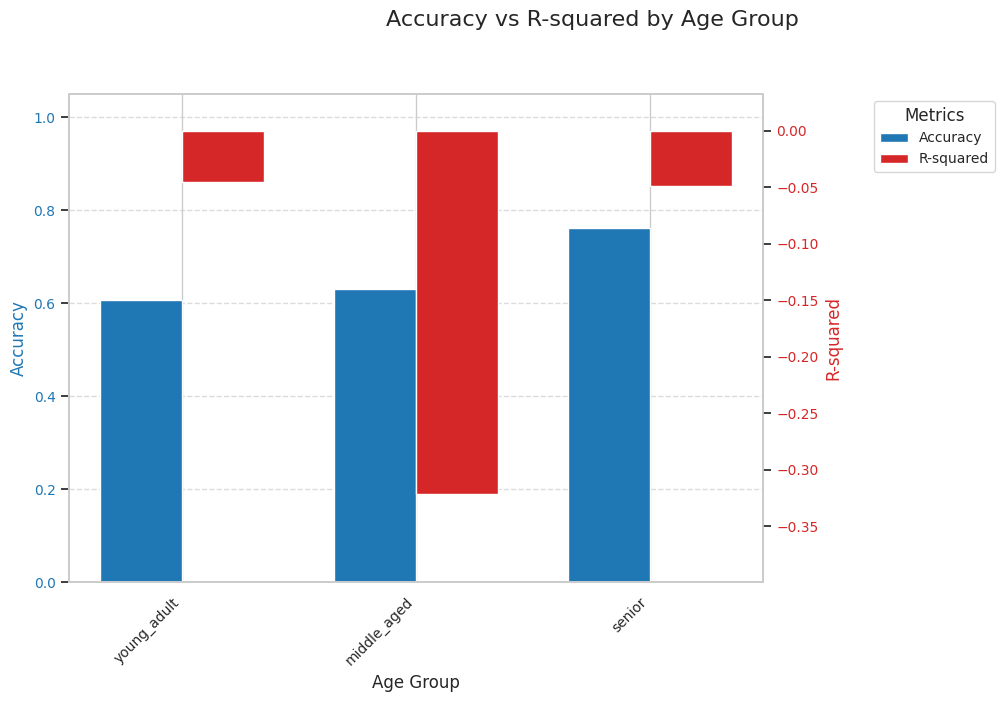

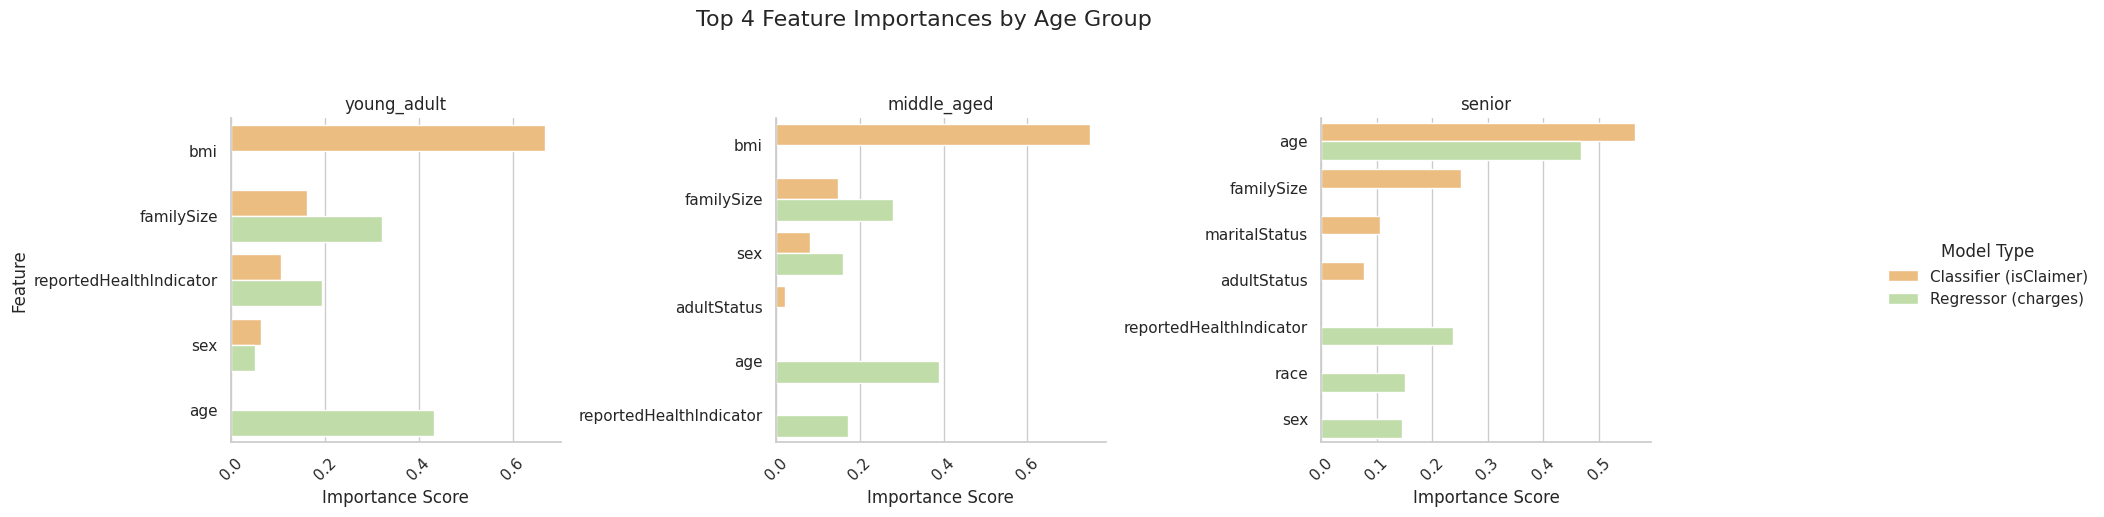


Analysis Complete.


In [ ]:
#Plots
import pandas as pd
import numpy as np
# Note: Modeling imports are not strictly needed if only plotting from hardcoded data,
# but kept here if you want to switch back later.
# from sklearn.feature_selection import SelectKBest, f_classif, f_regression
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for better plotting
import warnings

# --- Configuration for Labels ---
# Define mappings for Race and Region codes
race_map = {
    1: "1 White",
    2: "2 Black",
    3: "3 AmInd/AKNatv", # American Indian/Alaska Native
    4: "4 AsianInd",     # Asian Indian
    5: "5 Chinese",
    6: "6 Filipino",
    10: "10 OthAsian", # Other Asian (Shortened)
    12: "12 Multiple Races"
}

region_map = {
    1: "Northeast",
    2: "Midwest",
    3: "South",
    4: "West"
}

# Define a consistent order for age groups - Match the names used in the data exactly
# REMOVED 'child' as requested
age_order = ['young_adult', 'middle_aged', 'senior']


# --- Plotting Functions ---

def plot_performance(performance_df, group_col, group_label_order=None):
    """Generates bar plots comparing performance metrics across subgroups."""
    if performance_df.empty:
        print(f"No performance data to plot for {group_col}.")
        return

    # Define metric groups for plotting sections
    accuracy_metrics = ['Accuracy']
    class_1_metrics = ['Precision (Class 1)', 'Recall (Class 1)', 'F1-score (Class 1)']
    # regression_metrics = ['R-squared'] # Currently only R2 is plotted

    # Filter data for the specific group_col being plotted and remove rows where metric calculation failed
    # Use the passed dataframe directly, assuming it's already filtered
    df_plot = performance_df.dropna(subset=['value'])

    if df_plot.empty:
        print(f"No valid performance data to plot for {group_col} after dropping NAs.")
        return

    # Dynamically determine which sections to plot based on available metrics
    plot_sections = []
    available_metrics = df_plot['metric'].unique()
    if any(m in available_metrics for m in accuracy_metrics):
        plot_sections.append(accuracy_metrics)
    if any(m in available_metrics for m in class_1_metrics):
        plot_sections.append(class_1_metrics)
    # Add R2 *only* if it exists
    if 'R-squared' in available_metrics:
         plot_sections.append(['R-squared']) # Plot R2 in its own section/row

    n_rows = len(plot_sections)
    if n_rows == 0:
        print(f"No relevant metrics (Accuracy, Class 1 P/R/F1, R-squared) found to plot for {group_col}.")
        return

    # Create figure and axes, ensuring axes is always 2D array using squeeze=False
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, n_rows * 5), squeeze=False)
    fig.suptitle(f'Model Performance Comparison by {group_col.replace("_", " ").title()}', fontsize=16, y=1.02)
    plot_row_index = 0 # Tracks the current plot row

    # Determine plot order if provided
    # Filter plot_order to only include labels present in the current df_plot
    available_labels = df_plot['group_label'].unique()
    if group_label_order is not None:
        plot_order = [lbl for lbl in group_label_order if lbl in available_labels]
    else:
        plot_order = sorted(available_labels)

    if not plot_order:
        print(f"No groups left to plot for {group_col} after filtering.")
        plt.close(fig)
        return

    # Plot Accuracy (if metrics exist)
    if plot_row_index < n_rows and accuracy_metrics == plot_sections[plot_row_index]:
        acc_data = df_plot[df_plot['metric'] == 'Accuracy']
        if not acc_data.empty:
             current_ax = axes[plot_row_index, 0] # Access using [row, col]
             sns.barplot(x='group_label', y='value', data=acc_data, ax=current_ax, palette='viridis', order=plot_order)
             current_ax.set_title('Classifier Accuracy')
             current_ax.set_ylabel('Accuracy')
             current_ax.set_xlabel("") # Remove xlabel for intermediate plots
             # Apply rotation to tick labels directly
             current_ax.tick_params(axis='x', rotation=45) # Removed ha='right'
             # Alternative if alignment needed:
             # current_ax.set_xticklabels(current_ax.get_xticklabels(), rotation=45, ha='right')
             current_ax.set_ylim(0, 1.05) # Y-axis from 0 to 1 slightly padded
        plot_row_index += 1

    # Plot Precision, Recall, F1 for Class 1 (if metrics exist)
    if plot_row_index < n_rows and class_1_metrics == plot_sections[plot_row_index]:
        class1_data = df_plot[df_plot['metric'].isin(class_1_metrics)]
        if not class1_data.empty:
            current_ax = axes[plot_row_index, 0] # Access using [row, col]
            sns.barplot(x='group_label', y='value', hue='metric', data=class1_data, ax=current_ax, palette='magma', order=plot_order)
            current_ax.set_title('Classifier Metrics for Class 1 (Positive Class)') # Changed title slightly
            current_ax.set_ylabel('Score')
            current_ax.set_xlabel("") # Remove xlabel for intermediate plots
            current_ax.tick_params(axis='x', rotation=45) # Removed ha='right'
            # Move legend to the right
            current_ax.legend(title='Metric', bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)
            current_ax.set_ylim(0, 1.05) # Y-axis from 0 to 1 slightly padded
        plot_row_index += 1

    # Plot R-squared (if metric exists)
    if plot_row_index < n_rows and ['R-squared'] == plot_sections[plot_row_index]:
        r2_data = df_plot[df_plot['metric'] == 'R-squared']
        if not r2_data.empty:
            current_ax = axes[plot_row_index, 0] # Access using [row, col]
            sns.barplot(x='group_label', y='value', data=r2_data, ax=current_ax, palette='coolwarm', order=plot_order)
            current_ax.set_title('Regressor R-squared')
            current_ax.set_ylabel('R² Score')
            current_ax.set_xlabel(group_col.replace("_", " ").title()) # Add xlabel to the last plot
            current_ax.tick_params(axis='x', rotation=45) # Removed ha='right'
            # R2 can be negative, dynamic y-limits might be better
            min_r2, max_r2 = r2_data['value'].min(), r2_data['value'].max()
            padding = abs(max_r2 - min_r2) * 0.1 + 0.05 # Add padding
            current_ax.set_ylim(min(0, min_r2 - padding), max(0.1, max_r2 + padding)) # Ensure range covers data + 0 if positive
        plot_row_index += 1


    # Final adjustments
    if plot_row_index > 0: # Check if any plots were actually made
        # Add x-label to the very last subplot dynamically if it wasn't added already
        if not axes[plot_row_index-1, 0].get_xlabel():
             axes[plot_row_index-1, 0].set_xlabel(group_col.replace("_", " ").title())

        # Adjust layout tighter, leave space on right for legends if they exist
        try:
            has_legend = any(ax.get_legend() is not None for ax in axes.flat)
        except: # Handle potential older matplotlib versions or edge cases
            has_legend = True # Assume legend might exist to be safe

        right_margin = 0.9 if has_legend else 0.98 # Less margin if no legend
        fig.tight_layout(rect=[0, 0, right_margin, 0.97]) # Adjust rect right edge dynamically
    else:
        plt.close(fig) # Close the figure if it remained empty


def plot_feature_importance(importance_df, group_col, top_n=5, group_label_order=None):
    """Generates bar plots showing top N feature importances for each subgroup."""
    if importance_df.empty:
        print(f"No importance data to plot for {group_col}.")
        return
    # Use the passed dataframe directly, assuming it's already filtered
    df_plot = importance_df.copy()
    if df_plot.empty:
        print(f"No valid importance data to plot for {group_col}.")
        return

    # Calculate abs importance and get top N (Use top_n from function arg)
    df_plot['abs_importance'] = df_plot['importance'].abs()
    # Sort by original group value before getting top N if needed,
    # but here we sort by importance within group_label and model_type
    top_features = df_plot.sort_values(['group_label', 'model_type', 'abs_importance'], ascending=[True, True, False]) \
                         .groupby(['group_label', 'model_type']) \
                         .head(top_n)

    if top_features.empty:
         print(f"No feature importance data available after filtering for top {top_n} for {group_col}.")
         return

    # *** No need to modify labels here anymore, as they are correct in the input data ***

    # Determine plot order if provided
    # Filter plot_order to only include labels present in the current top_features
    available_labels = top_features['group_label'].unique()
    if group_label_order is not None:
        plot_order = [lbl for lbl in group_label_order if lbl in available_labels]
    else:
        plot_order = sorted(available_labels)

    if not plot_order:
        print(f"No groups left for importance plot for {group_col} after filtering.")
        return

    unique_groups = top_features['group_label'].unique()
    col_wrap_val = min(4, len(unique_groups))

    # Use catplot for faceted plotting
    g = sns.catplot(
        data=top_features, # Use the original top_features DataFrame
        y='feature',
        x='importance',
        col='group_label', # Use the label column for facets
        hue='model_type',  # This will now use the labels from the input data ('Classifier (isClaimer)')
        kind='bar',
        height=5,
        aspect=1.1,
        palette='Spectral',
        sharex=False,
        sharey=False,
        col_wrap=col_wrap_val,
        col_order=plot_order, # Control the order of facets
        dodge=True,
        legend_out=True # Keep legend outside plots initially
    )

    # Set overall title and facet titles
    g.fig.suptitle(f'Top {top_n} Feature Importances by {group_col.replace("_", " ").title()}', y=1.03, fontsize=16)
    g.set_titles(col_template="{col_name}") # Use the group label for facet title
    g.set_axis_labels("Importance Score", "Feature")
    # Rotate x-axis labels on each facet if needed (catplot often requires iterating through axes)
    for ax in g.axes.flat:
        # Rotate tick labels only if they exist
        if ax.get_xticklabels():
            ax.tick_params(axis='x', rotation=45) # Rotate x-axis labels

    # Adjust legend title and position
    try:
        # Move the existing legend object to the right
        sns.move_legend(g, loc='center left', bbox_to_anchor=(1.01, 0.5), title='Model Type') # You can still change the overall legend title here if you want
    except AttributeError:
         print("Could not automatically set legend title or position.")
    except ValueError as e:
        print(f"Could not move legend: {e}. May already be correctly placed or no legend exists.")


    # Adjust layout to prevent overlap and accommodate legend
    g.fig.tight_layout(rect=[0, 0, 0.9, 0.97]) # Adjust rect right edge


def plot_accuracy_r2_comparison(performance_df, group_col, group_label_order=None):
    """
    Plots Accuracy and R-squared side-by-side for each subgroup using dual Y-axes.
    Uses group_label for ticks, but maintains order based on original group values.
    """
    print(f"\n--- Generating Accuracy vs R-squared Plot for Group: {group_col} ---")
    if performance_df.empty:
        print(f"No performance data to plot for {group_col}.")
        return

    # Filter data for the specific group and required metrics
    df_plot = performance_df[
        performance_df['metric'].isin(['Accuracy', 'R-squared'])
    ].dropna(subset=['value'])

    if df_plot.empty:
        print(f"Skipping Accuracy/R-squared plot: No valid data for {group_col}.")
        return

    # Check if *both* metrics are present for at least one group
    metrics_present = df_plot.groupby('group_label')['metric'].nunique()
    groups_with_both = metrics_present[metrics_present == 2].index.tolist()

    if not groups_with_both:
        print(f"Skipping Accuracy/R-squared plot for {group_col}: No group has both 'Accuracy' and 'R-squared' values.")
        return
    # Filter df_plot to only include groups that have both metrics
    df_plot = df_plot[df_plot['group_label'].isin(groups_with_both)].copy()


    # Pivot table using the original numeric 'group' for potential sorting,
    # but keep 'group_label' for final labeling.
    pivot_df = None # Initialize
    try:
        # Use pivot_table to handle potential duplicate index/column pairs gracefully
        # Convert group to numeric first IF it's race or region, otherwise keep as is
        df_plot_copy = df_plot.copy() # Work on a copy to avoid modifying original
        if group_col in ['race', 'region']:
            df_plot_copy['group_numeric'] = pd.to_numeric(df_plot_copy['group'], errors='coerce')
        else:
            df_plot_copy['group_numeric'] = df_plot_copy['group'] # Keep original (e.g., string for age)

        pivot_df = df_plot_copy.pivot_table(index='group_numeric', columns='metric', values='value', aggfunc='first')
        # Attach labels back for lookup after potential sorting
        label_map_df = df_plot_copy[['group_numeric', 'group_label']].drop_duplicates().set_index('group_numeric')
        pivot_df = pivot_df.join(label_map_df)

    except Exception as e:
        print(f"Could not pivot/process data for Accuracy/R-squared plot. Error: {e}")
        return # Exit if pivoting fails

    # Check if both metrics columns exist after pivoting (and pivot_df was created)
    if pivot_df is None or 'Accuracy' not in pivot_df.columns or 'R-squared' not in pivot_df.columns:
        print("Skipping Accuracy/R-squared plot: One or both metric columns missing after pivoting or pivoting failed.")
        return

    # Drop rows where either Accuracy or R-squared is NaN after pivoting
    pivot_df.dropna(subset=['Accuracy', 'R-squared'], inplace=True)
    if pivot_df.empty:
        print("Skipping Accuracy/R-squared plot: No groups remaining after removing NaNs in Accuracy or R-squared.")
        return


    # Sort the pivot table based on the desired order
    final_pivot_df = None # Initialize
    if group_label_order:
         # If an explicit order of labels is given, use that to order the pivot table
        try:
            # Use group_label as index temporarily for reindexing
            pivot_df_temp = pivot_df.set_index('group_label')
            # Reindex based on the provided order, only keeping labels present in pivot_df_temp
            ordered_labels_present = [lbl for lbl in group_label_order if lbl in pivot_df_temp.index]
            final_pivot_df = pivot_df_temp.reindex(index=ordered_labels_present)

        except KeyError:
             print(f"Warning: Could not reindex using group_label for {group_col}. Resorting to default.")
             # Fallback if 'group_label' wasn't joined or error occurs
             if group_col in ['race', 'region']:
                 final_pivot_df = pivot_df.sort_index().set_index('group_label')
             else: # age_group or other
                 final_pivot_df = pivot_df.set_index('group_label').sort_index() # Sort alphabetically by label
    else:
         # Default sort: numeric for race/region, alphabetical for others (like age if order not given)
         if group_col in ['race', 'region']:
            final_pivot_df = pivot_df.sort_index().set_index('group_label') # Sort by numeric index, then use label for ticks
         else:
            final_pivot_df = pivot_df.set_index('group_label').sort_index() # Sort alphabetically by label

    # Check if there's data to plot after sorting/reindexing
    if final_pivot_df is None or final_pivot_df.empty:
        print("Skipping Accuracy/R-squared plot: No valid data points after processing and sorting.")
        return

    # Prepare for plotting
    groups_labels = final_pivot_df.index.astype(str) # Get labels from index
    x = np.arange(len(groups_labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax1 = plt.subplots(figsize=(12, 7)) # Increased height slightly for legend
    fig.suptitle(f'Accuracy vs R-squared by {group_col.replace("_", " ").title()}', fontsize=16, y=1.0)

    # --- Plot Accuracy on primary axis (ax1) ---
    color1 = 'tab:blue'
    acc_values = final_pivot_df['Accuracy'] # Don't fill NaN here, already dropped rows with NaN
    rects1 = ax1.bar(x - width/2, acc_values, width, label='Accuracy', color=color1)
    ax1.set_ylabel('Accuracy', color=color1, fontsize=12)
    ax1.set_ylim(0, 1.05) # Accuracy typically 0-1
    ax1.tick_params(axis='y', labelcolor=color1, labelsize=10)
    ax1.set_xticks(x)
    # Use set_xticklabels to apply rotation and alignment
    ax1.set_xticklabels(groups_labels, rotation=45, ha='right', fontsize=10)
    ax1.set_xlabel(group_col.replace("_", " ").title(), fontsize=12)
    ax1.grid(axis='y', linestyle='--', alpha=0.7) # Add horizontal grid

    # --- Plot R-squared on secondary axis (ax2) ---
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color2 = 'tab:red'
    r2_values = final_pivot_df['R-squared'] # Don't fill NaN here
    rects2 = ax2.bar(x + width/2, r2_values, width, label='R-squared', color=color2)
    ax2.set_ylabel('R-squared', color=color2, fontsize=12)
    # Adjust R-squared y-limits dynamically
    min_r2, max_r2 = r2_values.min(), r2_values.max()
    padding = abs(max_r2 - min_r2) * 0.1 + 0.05 # Add padding (ensure non-zero padding)
    # Ensure limits include 0 if range is positive, or slightly below min otherwise
    lower_lim = min(0, min_r2 - padding) if min_r2 <= 0 else 0 # Start at 0 if all R2 are positive
    upper_lim = max_r2 + padding
    # Handle case where min and max are very close (or same)
    if np.isclose(lower_lim, upper_lim):
        upper_lim += 0.1 # Add a small fixed padding
        if lower_lim == 0: # Adjust lower if it was 0
             lower_lim -= 0.05

    ax2.set_ylim(lower_lim, upper_lim)
    ax2.tick_params(axis='y', labelcolor=color2, labelsize=10)
    ax2.grid(None) # Turn off grid for secondary axis

    # Add combined legend to the right side
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    # Place legend outside on the upper right
    ax1.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.15, 1), ncol=1, fontsize=10, title="Metrics") # Adjusted anchor

    # Adjust layout to prevent overlap and make space for legend
    fig.tight_layout(rect=[0, 0, 0.88, 0.96]) # Adjust right margin


# --- Main Execution Block ---
if __name__ == "__main__":
    # Set plot style and resolution
    sns.set_theme(style="whitegrid")
    plt.rcParams['figure.dpi'] = 100
    # Suppress warnings (optional)
    # warnings.filterwarnings('ignore')

    # ==============================================================
    # **** Manually Create DataFrames from Your Text Output ****
    # ==============================================================
    # Updated Performance Data based on the latest output
    performance_data = [
        # --- Race ---
        {'group_col': 'race', 'group': 1, 'metric': 'Accuracy', 'value': 0.716875},
        {'group_col': 'race', 'group': 1, 'metric': 'Precision (Class 1)', 'value': 0.83},
        {'group_col': 'race', 'group': 1, 'metric': 'Recall (Class 1)', 'value': 0.81},
        {'group_col': 'race', 'group': 1, 'metric': 'F1-score (Class 1)', 'value': 0.82},
        {'group_col': 'race', 'group': 1, 'metric': 'R-squared', 'value': -0.3792389485238945},

        {'group_col': 'race', 'group': 2, 'metric': 'Accuracy', 'value': 0.6588628762541806},
        {'group_col': 'race', 'group': 2, 'metric': 'Precision (Class 1)', 'value': 0.76},
        {'group_col': 'race', 'group': 2, 'metric': 'Recall (Class 1)', 'value': 0.78},
        {'group_col': 'race', 'group': 2, 'metric': 'F1-score (Class 1)', 'value': 0.77},
        {'group_col': 'race', 'group': 2, 'metric': 'R-squared', 'value': -0.30603987251358467},

        {'group_col': 'race', 'group': 3, 'metric': 'Accuracy', 'value': 0.7894736842105263},
        {'group_col': 'race', 'group': 3, 'metric': 'Precision (Class 1)', 'value': 0.86},
        {'group_col': 'race', 'group': 3, 'metric': 'Recall (Class 1)', 'value': 0.86},
        {'group_col': 'race', 'group': 3, 'metric': 'F1-score (Class 1)', 'value': 0.86},
        {'group_col': 'race', 'group': 3, 'metric': 'R-squared', 'value': -0.3365445332929884},

        {'group_col': 'race', 'group': 4, 'metric': 'Accuracy', 'value': 0.7272727272727273},
        {'group_col': 'race', 'group': 4, 'metric': 'Precision (Class 1)', 'value': 0.81},
        {'group_col': 'race', 'group': 4, 'metric': 'Recall (Class 1)', 'value': 0.86},
        {'group_col': 'race', 'group': 4, 'metric': 'F1-score (Class 1)', 'value': 0.83},
        {'group_col': 'race', 'group': 4, 'metric': 'R-squared', 'value': -0.310680056645924},

        {'group_col': 'race', 'group': 5, 'metric': 'Accuracy', 'value': 0.7419354838709677},
        {'group_col': 'race', 'group': 5, 'metric': 'Precision (Class 1)', 'value': 0.88},
        {'group_col': 'race', 'group': 5, 'metric': 'Recall (Class 1)', 'value': 0.81},
        {'group_col': 'race', 'group': 5, 'metric': 'F1-score (Class 1)', 'value': 0.84},
        {'group_col': 'race', 'group': 5, 'metric': 'R-squared', 'value': -2.1043386441966354},

        {'group_col': 'race', 'group': 6, 'metric': 'Accuracy', 'value': 0.75},
        {'group_col': 'race', 'group': 6, 'metric': 'Precision (Class 1)', 'value': 0.85},
        {'group_col': 'race', 'group': 6, 'metric': 'Recall (Class 1)', 'value': 0.85},
        {'group_col': 'race', 'group': 6, 'metric': 'F1-score (Class 1)', 'value': 0.85},
        {'group_col': 'race', 'group': 6, 'metric': 'R-squared', 'value': -0.7374331058327759},

        {'group_col': 'race', 'group': 10, 'metric': 'Accuracy', 'value': 0.7346938775510204},
        {'group_col': 'race', 'group': 10, 'metric': 'Precision (Class 1)', 'value': 0.84},
        {'group_col': 'race', 'group': 10, 'metric': 'Recall (Class 1)', 'value': 0.82},
        {'group_col': 'race', 'group': 10, 'metric': 'F1-score (Class 1)', 'value': 0.83},
        {'group_col': 'race', 'group': 10, 'metric': 'R-squared', 'value': 0.16721092006678417},

        {'group_col': 'race', 'group': 12, 'metric': 'Accuracy', 'value': 0.7941176470588235},
        {'group_col': 'race', 'group': 12, 'metric': 'Precision (Class 1)', 'value': 0.83},
        {'group_col': 'race', 'group': 12, 'metric': 'Recall (Class 1)', 'value': 0.95},
        {'group_col': 'race', 'group': 12, 'metric': 'F1-score (Class 1)', 'value': 0.88},
        {'group_col': 'race', 'group': 12, 'metric': 'R-squared', 'value': -0.10390995755304999},

        # --- Region ---
        {'group_col': 'region', 'group': 1, 'metric': 'Accuracy', 'value': 0.774390243902439},
        {'group_col': 'region', 'group': 1, 'metric': 'Precision (Class 1)', 'value': 0.88},
        {'group_col': 'region', 'group': 1, 'metric': 'Recall (Class 1)', 'value': 0.86},
        {'group_col': 'region', 'group': 1, 'metric': 'F1-score (Class 1)', 'value': 0.87},
        {'group_col': 'region', 'group': 1, 'metric': 'R-squared', 'value': 0.03958871395316321},

        {'group_col': 'region', 'group': 2, 'metric': 'Accuracy', 'value': 0.7915742793791575},
        {'group_col': 'region', 'group': 2, 'metric': 'Precision (Class 1)', 'value': 0.86},
        {'group_col': 'region', 'group': 2, 'metric': 'Recall (Class 1)', 'value': 0.91},
        {'group_col': 'region', 'group': 2, 'metric': 'F1-score (Class 1)', 'value': 0.88},
        {'group_col': 'region', 'group': 2, 'metric': 'R-squared', 'value': -0.5270924202353859},

        {'group_col': 'region', 'group': 3, 'metric': 'Accuracy', 'value': 0.6540404040404041},
        {'group_col': 'region', 'group': 3, 'metric': 'Precision (Class 1)', 'value': 0.79},
        {'group_col': 'region', 'group': 3, 'metric': 'Recall (Class 1)', 'value': 0.72},
        {'group_col': 'region', 'group': 3, 'metric': 'F1-score (Class 1)', 'value': 0.75},
        {'group_col': 'region', 'group': 3, 'metric': 'R-squared', 'value': -0.278061748405773},

        {'group_col': 'region', 'group': 4, 'metric': 'Accuracy', 'value': 0.7450980392156863},
        {'group_col': 'region', 'group': 4, 'metric': 'Precision (Class 1)', 'value': 0.82},
        {'group_col': 'region', 'group': 4, 'metric': 'Recall (Class 1)', 'value': 0.87},
        {'group_col': 'region', 'group': 4, 'metric': 'F1-score (Class 1)', 'value': 0.85},
        {'group_col': 'region', 'group': 4, 'metric': 'R-squared', 'value': -0.24069076893688068},

        # --- Age Group (NAMES MUST MATCH age_order EXACTLY) ---
        # Age Group 'child' is explicitly skipped as requested
        # {'group_col': 'age_group', 'group': 'child', 'metric': 'Accuracy', 'value': np.nan},
        # {'group_col': 'age_group', 'group': 'child', 'metric': 'Precision (Class 1)', 'value': np.nan},
        # {'group_col': 'age_group', 'group': 'child', 'metric': 'Recall (Class 1)', 'value': np.nan},
        # {'group_col': 'age_group', 'group': 'child', 'metric': 'F1-score (Class 1)', 'value': np.nan},
        # {'group_col': 'age_group', 'group': 'child', 'metric': 'R-squared', 'value': -0.9610365959910407}, #<-Reg value might be needed if plotting R2 only

        {'group_col': 'age_group', 'group': 'middle_aged', 'metric': 'Accuracy', 'value': 0.6306954436450839},
        {'group_col': 'age_group', 'group': 'middle_aged', 'metric': 'Precision (Class 1)', 'value': 0.86},
        {'group_col': 'age_group', 'group': 'middle_aged', 'metric': 'Recall (Class 1)', 'value': 0.67},
        {'group_col': 'age_group', 'group': 'middle_aged', 'metric': 'F1-score (Class 1)', 'value': 0.75},
        {'group_col': 'age_group', 'group': 'middle_aged', 'metric': 'R-squared', 'value': -0.3217225948789735},

        {'group_col': 'age_group', 'group': 'senior', 'metric': 'Accuracy', 'value': 0.7612612612612613},
        {'group_col': 'age_group', 'group': 'senior', 'metric': 'Precision (Class 1)', 'value': 0.93},
        {'group_col': 'age_group', 'group': 'senior', 'metric': 'Recall (Class 1)', 'value': 0.80},
        {'group_col': 'age_group', 'group': 'senior', 'metric': 'F1-score (Class 1)', 'value': 0.86},
        {'group_col': 'age_group', 'group': 'senior', 'metric': 'R-squared', 'value': -0.0489773734586294},

        {'group_col': 'age_group', 'group': 'young_adult', 'metric': 'Accuracy', 'value': 0.6057781919850885},
        {'group_col': 'age_group', 'group': 'young_adult', 'metric': 'Precision (Class 1)', 'value': 0.78},
        {'group_col': 'age_group', 'group': 'young_adult', 'metric': 'Recall (Class 1)', 'value': 0.63},
        {'group_col': 'age_group', 'group': 'young_adult', 'metric': 'F1-score (Class 1)', 'value': 0.70},
        {'group_col': 'age_group', 'group': 'young_adult', 'metric': 'R-squared', 'value': -0.04513672272099112},
    ]
    # Add R2 for child if needed for R2-only plots, otherwise skip entirely
    # Commenting out for now as classifier metrics are missing
    # performance_data.append({'group_col': 'age_group', 'group': 'child', 'metric': 'R-squared', 'value': -0.9610365959910407})

    all_performance_results = pd.DataFrame(performance_data)

    # --- Updated Importance Data (label already changed here) ---
    importance_data = [
        # --- Race 1 ---
        {'group_col': 'race', 'group': 1, 'model_type': 'Classifier (isClaimer)', 'feature': 'age', 'importance': 0.4416}, # MODIFIED
        {'group_col': 'race', 'group': 1, 'model_type': 'Classifier (isClaimer)', 'feature': 'bmi', 'importance': 0.3803}, # MODIFIED
        {'group_col': 'race', 'group': 1, 'model_type': 'Classifier (isClaimer)', 'feature': 'familySize', 'importance': 0.1382}, # MODIFIED
        {'group_col': 'race', 'group': 1, 'model_type': 'Classifier (isClaimer)', 'feature': 'sex', 'importance': 0.0400}, # MODIFIED
        {'group_col': 'race', 'group': 1, 'model_type': 'Regressor (charges)', 'feature': 'age', 'importance': 0.4996},
        {'group_col': 'race', 'group': 1, 'model_type': 'Regressor (charges)', 'feature': 'familySize', 'importance': 0.2479},
        {'group_col': 'race', 'group': 1, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.1782},
        {'group_col': 'race', 'group': 1, 'model_type': 'Regressor (charges)', 'feature': 'sex', 'importance': 0.0743},
        # --- Race 2 ---
        {'group_col': 'race', 'group': 2, 'model_type': 'Classifier (isClaimer)', 'feature': 'age', 'importance': 0.6078}, # MODIFIED
        {'group_col': 'race', 'group': 2, 'model_type': 'Classifier (isClaimer)', 'feature': 'familySize', 'importance': 0.1870}, # MODIFIED
        {'group_col': 'race', 'group': 2, 'model_type': 'Classifier (isClaimer)', 'feature': 'reportedHealthIndicator', 'importance': 0.1411}, # MODIFIED
        {'group_col': 'race', 'group': 2, 'model_type': 'Classifier (isClaimer)', 'feature': 'sex', 'importance': 0.0642}, # MODIFIED
        {'group_col': 'race', 'group': 2, 'model_type': 'Regressor (charges)', 'feature': 'age', 'importance': 0.4518},
        {'group_col': 'race', 'group': 2, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.2567},
        {'group_col': 'race', 'group': 2, 'model_type': 'Regressor (charges)', 'feature': 'familySize', 'importance': 0.2179},
        {'group_col': 'race', 'group': 2, 'model_type': 'Regressor (charges)', 'feature': 'employmentStatus', 'importance': 0.0737},
        # --- Race 3 ---
        {'group_col': 'race', 'group': 3, 'model_type': 'Classifier (isClaimer)', 'feature': 'age', 'importance': 0.5767}, # MODIFIED
        {'group_col': 'race', 'group': 3, 'model_type': 'Classifier (isClaimer)', 'feature': 'bmi', 'importance': 0.2025}, # MODIFIED
        {'group_col': 'race', 'group': 3, 'model_type': 'Classifier (isClaimer)', 'feature': 'familySize', 'importance': 0.1752}, # MODIFIED
        {'group_col': 'race', 'group': 3, 'model_type': 'Classifier (isClaimer)', 'feature': 'employmentStatus', 'importance': 0.0456}, # MODIFIED
        {'group_col': 'race', 'group': 3, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.7065},
        {'group_col': 'race', 'group': 3, 'model_type': 'Regressor (charges)', 'feature': 'bmi', 'importance': 0.1699},
        {'group_col': 'race', 'group': 3, 'model_type': 'Regressor (charges)', 'feature': 'sex', 'importance': 0.0852},
        {'group_col': 'race', 'group': 3, 'model_type': 'Regressor (charges)', 'feature': 'adultStatus', 'importance': 0.0385},
        # --- Race 4 ---
        {'group_col': 'race', 'group': 4, 'model_type': 'Classifier (isClaimer)', 'feature': 'age', 'importance': 0.5788}, # MODIFIED
        {'group_col': 'race', 'group': 4, 'model_type': 'Classifier (isClaimer)', 'feature': 'bmi', 'importance': 0.3443}, # MODIFIED
        {'group_col': 'race', 'group': 4, 'model_type': 'Classifier (isClaimer)', 'feature': 'maritalStatus', 'importance': 0.0429}, # MODIFIED
        {'group_col': 'race', 'group': 4, 'model_type': 'Classifier (isClaimer)', 'feature': 'adultStatus', 'importance': 0.0341}, # MODIFIED
        {'group_col': 'race', 'group': 4, 'model_type': 'Regressor (charges)', 'feature': 'region', 'importance': 0.3153},
        {'group_col': 'race', 'group': 4, 'model_type': 'Regressor (charges)', 'feature': 'familySize', 'importance': 0.3136},
        {'group_col': 'race', 'group': 4, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.2966},
        {'group_col': 'race', 'group': 4, 'model_type': 'Regressor (charges)', 'feature': 'maritalStatus', 'importance': 0.0746},
        # --- Race 5 ---
        {'group_col': 'race', 'group': 5, 'model_type': 'Classifier (isClaimer)', 'feature': 'bmi', 'importance': 0.4448}, # MODIFIED
        {'group_col': 'race', 'group': 5, 'model_type': 'Classifier (isClaimer)', 'feature': 'familySize', 'importance': 0.3105}, # MODIFIED
        {'group_col': 'race', 'group': 5, 'model_type': 'Classifier (isClaimer)', 'feature': 'reportedHealthIndicator', 'importance': 0.1750}, # MODIFIED
        {'group_col': 'race', 'group': 5, 'model_type': 'Classifier (isClaimer)', 'feature': 'adultStatus', 'importance': 0.0697}, # MODIFIED
        {'group_col': 'race', 'group': 5, 'model_type': 'Regressor (charges)', 'feature': 'familySize', 'importance': 0.5307},
        {'group_col': 'race', 'group': 5, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.2686},
        {'group_col': 'race', 'group': 5, 'model_type': 'Regressor (charges)', 'feature': 'maritalStatus', 'importance': 0.1496},
        {'group_col': 'race', 'group': 5, 'model_type': 'Regressor (charges)', 'feature': 'employmentStatus', 'importance': 0.0510},
         # --- Race 6 ---
        {'group_col': 'race', 'group': 6, 'model_type': 'Classifier (isClaimer)', 'feature': 'age', 'importance': 0.7452}, # MODIFIED
        {'group_col': 'race', 'group': 6, 'model_type': 'Classifier (isClaimer)', 'feature': 'reportedHealthIndicator', 'importance': 0.1627}, # MODIFIED
        {'group_col': 'race', 'group': 6, 'model_type': 'Classifier (isClaimer)', 'feature': 'maritalStatus', 'importance': 0.0863}, # MODIFIED
        {'group_col': 'race', 'group': 6, 'model_type': 'Classifier (isClaimer)', 'feature': 'employmentStatus', 'importance': 0.0057}, # MODIFIED
        {'group_col': 'race', 'group': 6, 'model_type': 'Regressor (charges)', 'feature': 'bmi', 'importance': 0.8111},
        {'group_col': 'race', 'group': 6, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.1728},
        {'group_col': 'race', 'group': 6, 'model_type': 'Regressor (charges)', 'feature': 'maritalStatus', 'importance': 0.0133},
        {'group_col': 'race', 'group': 6, 'model_type': 'Regressor (charges)', 'feature': 'adultStatus', 'importance': 0.0027},
        # --- Race 10 ---
        {'group_col': 'race', 'group': 10, 'model_type': 'Classifier (isClaimer)', 'feature': 'bmi', 'importance': 0.5790}, # MODIFIED
        {'group_col': 'race', 'group': 10, 'model_type': 'Classifier (isClaimer)', 'feature': 'reportedHealthIndicator', 'importance': 0.2433}, # MODIFIED
        {'group_col': 'race', 'group': 10, 'model_type': 'Classifier (isClaimer)', 'feature': 'adultStatus', 'importance': 0.1008}, # MODIFIED
        {'group_col': 'race', 'group': 10, 'model_type': 'Classifier (isClaimer)', 'feature': 'maritalStatus', 'importance': 0.0769}, # MODIFIED
        {'group_col': 'race', 'group': 10, 'model_type': 'Regressor (charges)', 'feature': 'age', 'importance': 0.5433},
        {'group_col': 'race', 'group': 10, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.1723},
        {'group_col': 'race', 'group': 10, 'model_type': 'Regressor (charges)', 'feature': 'familySize', 'importance': 0.1716},
        {'group_col': 'race', 'group': 10, 'model_type': 'Regressor (charges)', 'feature': 'sex', 'importance': 0.1127},
         # --- Race 12 ---
        {'group_col': 'race', 'group': 12, 'model_type': 'Classifier (isClaimer)', 'feature': 'age', 'importance': 0.6481}, # MODIFIED
        {'group_col': 'race', 'group': 12, 'model_type': 'Classifier (isClaimer)', 'feature': 'reportedHealthIndicator', 'importance': 0.1560}, # MODIFIED
        {'group_col': 'race', 'group': 12, 'model_type': 'Classifier (isClaimer)', 'feature': 'sex', 'importance': 0.1294}, # MODIFIED
        {'group_col': 'race', 'group': 12, 'model_type': 'Classifier (isClaimer)', 'feature': 'maritalStatus', 'importance': 0.0665}, # MODIFIED
        {'group_col': 'race', 'group': 12, 'model_type': 'Regressor (charges)', 'feature': 'age', 'importance': 0.6301},
        {'group_col': 'race', 'group': 12, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.1913},
        {'group_col': 'race', 'group': 12, 'model_type': 'Regressor (charges)', 'feature': 'maritalStatus', 'importance': 0.0944},
        {'group_col': 'race', 'group': 12, 'model_type': 'Regressor (charges)', 'feature': 'sex', 'importance': 0.0842},
         # --- Region 1 ---
        {'group_col': 'region', 'group': 1, 'model_type': 'Classifier (isClaimer)', 'feature': 'age', 'importance': 0.5245}, # MODIFIED
        {'group_col': 'region', 'group': 1, 'model_type': 'Classifier (isClaimer)', 'feature': 'bmi', 'importance': 0.2749}, # MODIFIED
        {'group_col': 'region', 'group': 1, 'model_type': 'Classifier (isClaimer)', 'feature': 'familySize', 'importance': 0.1694}, # MODIFIED
        {'group_col': 'region', 'group': 1, 'model_type': 'Classifier (isClaimer)', 'feature': 'adultStatus', 'importance': 0.0313}, # MODIFIED
        {'group_col': 'region', 'group': 1, 'model_type': 'Regressor (charges)', 'feature': 'age', 'importance': 0.5059},
        {'group_col': 'region', 'group': 1, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.2448},
        {'group_col': 'region', 'group': 1, 'model_type': 'Regressor (charges)', 'feature': 'familySize', 'importance': 0.1881},
        {'group_col': 'region', 'group': 1, 'model_type': 'Regressor (charges)', 'feature': 'sex', 'importance': 0.0611},
         # --- Region 2 ---
        {'group_col': 'region', 'group': 2, 'model_type': 'Classifier (isClaimer)', 'feature': 'age', 'importance': 0.4758}, # MODIFIED
        {'group_col': 'region', 'group': 2, 'model_type': 'Classifier (isClaimer)', 'feature': 'bmi', 'importance': 0.3190}, # MODIFIED
        {'group_col': 'region', 'group': 2, 'model_type': 'Classifier (isClaimer)', 'feature': 'familySize', 'importance': 0.1597}, # MODIFIED
        {'group_col': 'region', 'group': 2, 'model_type': 'Classifier (isClaimer)', 'feature': 'sex', 'importance': 0.0455}, # MODIFIED
        {'group_col': 'region', 'group': 2, 'model_type': 'Regressor (charges)', 'feature': 'age', 'importance': 0.4840},
        {'group_col': 'region', 'group': 2, 'model_type': 'Regressor (charges)', 'feature': 'familySize', 'importance': 0.2874},
        {'group_col': 'region', 'group': 2, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.1973},
        {'group_col': 'region', 'group': 2, 'model_type': 'Regressor (charges)', 'feature': 'employmentStatus', 'importance': 0.0313},
        # --- Region 3 ---
        {'group_col': 'region', 'group': 3, 'model_type': 'Classifier (isClaimer)', 'feature': 'age', 'importance': 0.6731}, # MODIFIED
        {'group_col': 'region', 'group': 3, 'model_type': 'Classifier (isClaimer)', 'feature': 'familySize', 'importance': 0.1986}, # MODIFIED
        {'group_col': 'region', 'group': 3, 'model_type': 'Classifier (isClaimer)', 'feature': 'sex', 'importance': 0.0745}, # MODIFIED
        {'group_col': 'region', 'group': 3, 'model_type': 'Classifier (isClaimer)', 'feature': 'maritalStatus', 'importance': 0.0538}, # MODIFIED
        {'group_col': 'region', 'group': 3, 'model_type': 'Regressor (charges)', 'feature': 'age', 'importance': 0.4462},
        {'group_col': 'region', 'group': 3, 'model_type': 'Regressor (charges)', 'feature': 'familySize', 'importance': 0.2577},
        {'group_col': 'region', 'group': 3, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.1778},
        {'group_col': 'region', 'group': 3, 'model_type': 'Regressor (charges)', 'feature': 'sex', 'importance': 0.1182},
         # --- Region 4 ---
        {'group_col': 'region', 'group': 4, 'model_type': 'Classifier (isClaimer)', 'feature': 'age', 'importance': 0.5046}, # MODIFIED
        {'group_col': 'region', 'group': 4, 'model_type': 'Classifier (isClaimer)', 'feature': 'bmi', 'importance': 0.3203}, # MODIFIED
        {'group_col': 'region', 'group': 4, 'model_type': 'Classifier (isClaimer)', 'feature': 'familySize', 'importance': 0.1519}, # MODIFIED
        {'group_col': 'region', 'group': 4, 'model_type': 'Classifier (isClaimer)', 'feature': 'adultStatus', 'importance': 0.0233}, # MODIFIED
        {'group_col': 'region', 'group': 4, 'model_type': 'Regressor (charges)', 'feature': 'age', 'importance': 0.3747},
        {'group_col': 'region', 'group': 4, 'model_type': 'Regressor (charges)', 'feature': 'familySize', 'importance': 0.3443},
        {'group_col': 'region', 'group': 4, 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.2249},
        {'group_col': 'region', 'group': 4, 'model_type': 'Regressor (charges)', 'feature': 'sex', 'importance': 0.0560},
        # --- Age Group child --- Skipped as requested
        # {'group_col': 'age_group', 'group': 'child', 'model_type': 'Regressor (charges)', 'feature': 'race', 'importance': 0.6397},
        # {'group_col': 'age_group', 'group': 'child', 'model_type': 'Regressor (charges)', 'feature': 'region', 'importance': 0.2853},
        # {'group_col': 'age_group', 'group': 'child', 'model_type': 'Regressor (charges)', 'feature': 'employmentStatus', 'importance': 0.0679},
        # {'group_col': 'age_group', 'group': 'child', 'model_type': 'Regressor (charges)', 'feature': 'sex', 'importance': 0.0070},
        # --- Age Group middle_aged ---
        {'group_col': 'age_group', 'group': 'middle_aged', 'model_type': 'Classifier (isClaimer)', 'feature': 'bmi', 'importance': 0.7500}, # MODIFIED
        {'group_col': 'age_group', 'group': 'middle_aged', 'model_type': 'Classifier (isClaimer)', 'feature': 'familySize', 'importance': 0.1475}, # MODIFIED
        {'group_col': 'age_group', 'group': 'middle_aged', 'model_type': 'Classifier (isClaimer)', 'feature': 'sex', 'importance': 0.0822}, # MODIFIED
        {'group_col': 'age_group', 'group': 'middle_aged', 'model_type': 'Classifier (isClaimer)', 'feature': 'adultStatus', 'importance': 0.0203}, # MODIFIED
        {'group_col': 'age_group', 'group': 'middle_aged', 'model_type': 'Regressor (charges)', 'feature': 'age', 'importance': 0.3889},
        {'group_col': 'age_group', 'group': 'middle_aged', 'model_type': 'Regressor (charges)', 'feature': 'familySize', 'importance': 0.2790},
        {'group_col': 'age_group', 'group': 'middle_aged', 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.1716},
        {'group_col': 'age_group', 'group': 'middle_aged', 'model_type': 'Regressor (charges)', 'feature': 'sex', 'importance': 0.1604},
         # --- Age Group senior ---
        {'group_col': 'age_group', 'group': 'senior', 'model_type': 'Classifier (isClaimer)', 'feature': 'age', 'importance': 0.5653}, # MODIFIED
        {'group_col': 'age_group', 'group': 'senior', 'model_type': 'Classifier (isClaimer)', 'feature': 'familySize', 'importance': 0.2512}, # MODIFIED
        {'group_col': 'age_group', 'group': 'senior', 'model_type': 'Classifier (isClaimer)', 'feature': 'maritalStatus', 'importance': 0.1062}, # MODIFIED
        {'group_col': 'age_group', 'group': 'senior', 'model_type': 'Classifier (isClaimer)', 'feature': 'adultStatus', 'importance': 0.0773}, # MODIFIED
        {'group_col': 'age_group', 'group': 'senior', 'model_type': 'Regressor (charges)', 'feature': 'age', 'importance': 0.4676},
        {'group_col': 'age_group', 'group': 'senior', 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.2366},
        {'group_col': 'age_group', 'group': 'senior', 'model_type': 'Regressor (charges)', 'feature': 'race', 'importance': 0.1510},
        {'group_col': 'age_group', 'group': 'senior', 'model_type': 'Regressor (charges)', 'feature': 'sex', 'importance': 0.1448},
        # --- Age Group young_adult ---
        {'group_col': 'age_group', 'group': 'young_adult', 'model_type': 'Classifier (isClaimer)', 'feature': 'bmi', 'importance': 0.6689}, # MODIFIED
        {'group_col': 'age_group', 'group': 'young_adult', 'model_type': 'Classifier (isClaimer)', 'feature': 'familySize', 'importance': 0.1615}, # MODIFIED
        {'group_col': 'age_group', 'group': 'young_adult', 'model_type': 'Classifier (isClaimer)', 'feature': 'reportedHealthIndicator', 'importance': 0.1062}, # MODIFIED
        {'group_col': 'age_group', 'group': 'young_adult', 'model_type': 'Classifier (isClaimer)', 'feature': 'sex', 'importance': 0.0634}, # MODIFIED
        {'group_col': 'age_group', 'group': 'young_adult', 'model_type': 'Regressor (charges)', 'feature': 'age', 'importance': 0.4326},
        {'group_col': 'age_group', 'group': 'young_adult', 'model_type': 'Regressor (charges)', 'feature': 'familySize', 'importance': 0.3216},
        {'group_col': 'age_group', 'group': 'young_adult', 'model_type': 'Regressor (charges)', 'feature': 'reportedHealthIndicator', 'importance': 0.1940},
        {'group_col': 'age_group', 'group': 'young_adult', 'model_type': 'Regressor (charges)', 'feature': 'sex', 'importance': 0.0517},
    ]
    all_importance_results = pd.DataFrame(importance_data)


    # --- Add Group Labels based on Mappings ---
    def get_label(row):
        if row['group_col'] == 'race':
            # Ensure group is int for lookup
            return race_map.get(int(row['group']), str(row['group']))
        elif row['group_col'] == 'region':
             # Ensure group is int for lookup
            return region_map.get(int(row['group']), str(row['group']))
        elif row['group_col'] == 'age_group':
            # Check if the group is 'child' and return None or skip
            if str(row['group']) == 'child':
                return None # Indicate skipping this row for labeling
            return str(row['group'])
        else:
            return str(row['group'])

    all_performance_results['group_label'] = all_performance_results.apply(get_label, axis=1)
    all_importance_results['group_label'] = all_importance_results.apply(get_label, axis=1)

    # Drop rows where label could not be assigned (e.g., child group)
    all_performance_results.dropna(subset=['group_label'], inplace=True)
    all_importance_results.dropna(subset=['group_label'], inplace=True)


    # --- Plotting Loop ---
    grouping_columns = ['race', 'region', 'age_group']

    for group_col in grouping_columns:
        print(f"\n--- Generating Plots for Group: {group_col} ---")

        # Filter the DataFrames for the current group
        perf_df = all_performance_results[all_performance_results['group_col'] == group_col].copy()
        imp_df = all_importance_results[all_importance_results['group_col'] == group_col].copy()

        if perf_df.empty and imp_df.empty:
             print(f"No data found for group '{group_col}' in the provided results (excluding 'child').")
             continue

        # --- Determine Plotting Order ---
        ordered_labels = None
        # Use perf_df to determine order as it's used in most plots
        # Ensure 'group' is numeric for sorting race/region before getting labels
        if not perf_df.empty:
            # Convert 'group' to numeric for sorting where applicable, handle errors
            if group_col in ['race', 'region']:
                try:
                    # Use a temporary column to avoid overwriting original 'group'
                    perf_df['group_numeric_sort'] = pd.to_numeric(perf_df['group'])
                except ValueError:
                    print(f"Warning: Could not convert 'group' to numeric for sorting {group_col}. Using string sort.")
                    perf_df['group_numeric_sort'] = perf_df['group'].astype(str) # Fallback to string sort
                # Get unique labels in the correct order by sorting by numeric group
                unique_groups_df = perf_df[['group_numeric_sort', 'group_label']].drop_duplicates()
                ordered_labels = unique_groups_df.sort_values('group_numeric_sort')['group_label'].tolist()

            elif group_col == 'age_group':
                 # Use the predefined age order, filtering for those present in the data
                 # age_order already excludes 'child'
                present_ages = perf_df['group_label'].unique()
                ordered_labels = [age for age in age_order if age in present_ages]
            else: # Fallback for any other group_col type
                 # Get unique labels sorted alphabetically by label if no other logic applies
                 ordered_labels = sorted(perf_df['group_label'].unique())


        # --- Call Plotting Functions ---
        # Pass the filtered data and the calculated order
        plot_performance(perf_df, group_col, group_label_order=ordered_labels)
        plot_accuracy_r2_comparison(perf_df, group_col, group_label_order=ordered_labels)
        # Pass filtered imp_df data and the calculated order for feature importance facets
        # Update top_n to 4 as most groups now have 4 features listed
        plot_feature_importance(imp_df, group_col, top_n=4, group_label_order=ordered_labels)

    # Display all plots generated after the loop finishes
    print("\nDisplaying generated plots...")
    plt.show()

    print("\nAnalysis Complete.")

In [ ]:
#real data to test Kaggle model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder # Keep LE just in case
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# **** Import evaluation metrics ****
from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_squared_error
import warnings

# Suppress warnings if needed
warnings.filterwarnings('ignore', category=FutureWarning)

print("#### PART 1: Training Model 1 (from Insurance.csv) ####")

# --- Code Block from your FIRST script (Training Model 1) ---
# (Includes training clf_model1, reg_model1 and fitting scaler, selector)
# ... (Same as previous code block for Part 1) ...
try:
    df_train_model1 = pd.read_csv('/content/drive/MyDrive/Kaggle/Insurance.csv')
    df_train_model1 = df_train_model1.dropna()

    model1_features_expected = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']

    model1_label_encoders = {}
    categorical_columns_model1 = df_train_model1.select_dtypes(include=['object']).columns
    for col in categorical_columns_model1:
        if col in model1_features_expected:
            le = LabelEncoder()
            df_train_model1[col] = le.fit_transform(df_train_model1[col])
            model1_label_encoders[col] = le
            print(f"Fitted LabelEncoder for unexpected object column '{col}'.")
    if not model1_label_encoders:
        print("Confirmed: No object-type columns found among expected features for LabelEncoding.")

    target_classification = 'insuranceclaim'
    target_regression = 'charges'

    missing_features = [f for f in model1_features_expected if f not in df_train_model1.columns]
    if missing_features:
        raise ValueError(f"Missing expected features in Insurance.csv: {missing_features}")
    if target_classification not in df_train_model1.columns or target_regression not in df_train_model1.columns:
         raise ValueError(f"Missing target columns ('{target_classification}' or '{target_regression}') in Insurance.csv")

    X_model1 = df_train_model1[model1_features_expected].copy()
    y_classification_model1 = df_train_model1[target_classification]
    y_regression_model1 = df_train_model1[target_regression]
    model1_feature_names = list(X_model1.columns)

    model1_scaler = StandardScaler()
    X_scaled_model1 = model1_scaler.fit_transform(X_model1)

    model1_selector = SelectKBest(f_classif, k=4)
    X_selected_model1 = model1_selector.fit_transform(X_scaled_model1, y_classification_model1)
    selected_feature_names_model1 = X_model1.columns[model1_selector.get_support()]
    print(f"Model 1 Features used for training (after selection): {list(selected_feature_names_model1)}")

    clf_model1 = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_model1.fit(X_selected_model1, y_classification_model1)
    print("Model 1 Classifier Trained.")

    reg_model1 = RandomForestRegressor(n_estimators=100, random_state=42)
    reg_model1.fit(X_selected_model1, y_regression_model1)
    print("Model 1 Regressor Trained.")

except FileNotFoundError:
    print("ERROR: Could not find '/content/drive/MyDrive/Kaggle/Insurance.csv'. Cannot train Model 1.")
    exit()
except KeyError as e:
    print(f"ERROR: Missing expected column during training setup: {e}.")
    exit()
except ValueError as e:
     print(f"ERROR: {e}")
     exit()
except Exception as e:
    print(f"An unexpected error occurred during Model 1 training: {e}")
    exit()


# --- Simplified Prediction Function (Not used for bulk prediction, but kept for single) ---
def predict_insurance_claim(input_data):
    """Predicts using Model 1 for a single input dictionary."""
    input_df = pd.DataFrame([input_data])
    try:
        input_df = input_df.reindex(columns=model1_feature_names, fill_value=0)
    except Exception as e:
        print(f"Error reindexing input data: {e}. Expected columns: {model1_feature_names}")
        raise
    input_scaled = model1_scaler.transform(input_df)
    input_selected = model1_selector.transform(input_scaled)
    claim_prob = clf_model1.predict_proba(input_selected)[:, 1][0]
    claim_amount = reg_model1.predict(input_selected)[0]
    return claim_prob, claim_amount
# --- End of prediction function ---


print("\n#### PART 2: Loading and Processing h243.csv Data ####")

# --- Function to process h243.csv data (NOW DROPS ROWS WITH NA IN TARGETS TOO) ---
def read_data_h243(path):
    """Loads and preprocesses h243.csv, keeping rows where features AND actual targets are non-missing."""
    try:
        df_raw = pd.read_csv(path)
    except FileNotFoundError:
        print(f"ERROR: Test data file not found at {path}")
        return None
    df_raw = df_raw.drop_duplicates()

    df = pd.DataFrame()
    required_cols = ['AGELAST', 'SEX', 'ADBMI42', 'FAMSZE22', 'OFTSMK53', 'REGION22', 'INSAT22X', 'TOTEXP22']
    missing_cols = [col for col in required_cols if col not in df_raw.columns]
    if missing_cols:
        print(f"ERROR: Missing required columns in {path}: {missing_cols}")
        return None

    # Features for Model 1 mapping
    df['h243_age'] = df_raw['AGELAST']
    df['h243_sex'] = df_raw['SEX']
    df['h243_bmi'] = df_raw['ADBMI42'].replace(-1, np.nan)
    df['h243_familySize'] = df_raw['FAMSZE22']
    df['h243_smokingStatus'] = df_raw['OFTSMK53'].apply(lambda col: 1 if pd.notna(col) and col in [1, 2] else (0 if pd.notna(col) and col == 3 else pd.NA))
    df['h243_region'] = df_raw['REGION22']

    # Actual values from h243 for comparison
    df['h243_actual_claim_status'] = df_raw['INSAT22X'].map({1: 1, 2: 0}) # Map 1/2 to 1/0
    df['h243_actual_charges'] = df_raw['TOTEXP22']

    # Define columns needed (features + actuals)
    map_cols_features = ['h243_age', 'h243_sex', 'h243_bmi', 'h243_familySize', 'h243_smokingStatus', 'h243_region']
    map_cols_actuals = ['h243_actual_claim_status', 'h243_actual_charges']
    all_needed_cols = map_cols_features + map_cols_actuals

    df_relevant = df[all_needed_cols].copy()

    # --- Drop rows if ANY needed column (feature or actual target) has NA ---
    initial_rows = len(df_relevant)
    df_relevant = df_relevant.dropna(subset=all_needed_cols) # Drop based on ALL needed columns
    print(f"Loaded and processed h243 data. Kept {len(df_relevant)} of {initial_rows} rows (removed rows with missing values in required features OR actual targets).")

    # Convert types after dropping all NAs
    df_relevant = df_relevant.astype({
        'h243_age': int, 'h243_sex': int, 'h243_bmi': float,
        'h243_familySize': int, 'h243_smokingStatus': int, 'h243_region': int,
        'h243_actual_claim_status': int, # Can be int now as NAs are dropped
        'h243_actual_charges': float
    })
    return df_relevant

# --- Load the h243 data ---
df_h243_processed = read_data_h243('/content/drive/MyDrive/Kaggle/h243.csv')
# --- End of h243 processing ---


print("\n#### PART 3: Evaluating Model 1 on Processed h243 Data ####")

if df_h243_processed is not None and not df_h243_processed.empty:

    # --- Prepare Data for Bulk Prediction ---
    print(f"Preparing {len(df_h243_processed)} rows from h243 for evaluation...")
    X_test_h243 = pd.DataFrame()
    # Map features from h243 to the format Model 1 expects
    X_test_h243['age'] = df_h243_processed['h243_age']
    X_test_h243['bmi'] = df_h243_processed['h243_bmi']
    X_test_h243['children'] = df_h243_processed['h243_familySize'] - 2
    X_test_h243['sex'] = df_h243_processed['h243_sex'].apply(lambda x: 1 if x == 1 else 0) # Map 1/2 -> 1/0
    X_test_h243['smoker'] = df_h243_processed['h243_smokingStatus'] # Already 0/1
    X_test_h243['region'] = df_h243_processed['h243_region'] # Assuming direct code map

    # Ensure correct column order
    X_test_h243 = X_test_h243[model1_feature_names]

    # Extract actual target values
    y_actual_class_h243 = df_h243_processed['h243_actual_claim_status']
    y_actual_reg_h243 = df_h243_processed['h243_actual_charges']

    # --- Preprocess features using Model 1's scaler and selector ---
    print("Preprocessing test data...")
    X_test_scaled = model1_scaler.transform(X_test_h243)
    X_test_selected = model1_selector.transform(X_test_scaled)

    # --- Make Predictions ---
    print("Making predictions...")
    y_pred_class_h243 = clf_model1.predict(X_test_selected)
    y_pred_reg_h243 = reg_model1.predict(X_test_selected)

    # --- Evaluate Performance ---
    print("\n--- Model 1 Performance Evaluation on h243 Data ---")

    # Classifier Evaluation
    print("\nClassifier Performance:")
    accuracy = accuracy_score(y_actual_class_h243, y_pred_class_h243)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    # Use zero_division=0 parameter to avoid warnings if a class has no predicted samples
    print(classification_report(y_actual_class_h243, y_pred_class_h243, zero_division=0))

    # Regressor Evaluation
    print("\nRegressor Performance:")
    r2 = r2_score(y_actual_reg_h243, y_pred_reg_h243)
    rmse = np.sqrt(mean_squared_error(y_actual_reg_h243, y_pred_reg_h243))
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")

    # --- (Optional) Show comparison for the first few rows ---
    print("\n--- Sample Comparison (First 5 Rows) ---")
    comparison_df = pd.DataFrame({
        'Actual Claim Status': y_actual_class_h243,
        'Predicted Claim Status': y_pred_class_h243,
        'Actual Charges': y_actual_reg_h243,
        'Predicted Charges': y_pred_reg_h243
    }).head()
    print(comparison_df.to_string(formatters={'Actual Charges': '${:,.2f}'.format, 'Predicted Charges': '${:,.2f}'.format}))


else:
    print("\nCould not load or process h243 data, or no valid rows remained for evaluation.")

print("\n#### Script Finished ####")

#### PART 1: Training Model 1 (from Insurance.csv) ####
Confirmed: No object-type columns found among expected features for LabelEncoding.
Model 1 Features used for training (after selection): ['age', 'bmi', 'children', 'smoker']
Model 1 Classifier Trained.
Model 1 Regressor Trained.

#### PART 2: Loading and Processing h243.csv Data ####
Loaded and processed h243 data. Kept 11213 of 22431 rows (removed rows with missing values in required features OR actual targets).

#### PART 3: Evaluating Model 1 on Processed h243 Data ####
Preparing 11213 rows from h243 for evaluation...
Preprocessing test data...
Making predictions...

--- Model 1 Performance Evaluation on h243 Data ---

Classifier Performance:
Accuracy: 0.5635
Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.44      0.13       865
           1       0.92      0.57      0.71     10348

    accuracy                           0.56     11213
   macro avg       0.50      0.5